# Classification of ag plastics across California

Sentinel-2 classification of agricultural plastic use in California based on Harvard students' capstone project and Yuanyuan's internship project

Notebook authored by Annie Taylor, July 2024

Some key changes from previous analyses:
* Using validated training datasets (edited, added precise dates)
* Using different cloud-masking algorithm
* Using updated index equations
* Random stratified sample within polygons instead of sampling every point

### Set up ee api and packages

In [1]:
import ee
import geemap
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from IPython.display import display, HTML
from datetime import datetime, timedelta
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import geopandas as gpd
import altair as alt
import rasterio #used for pt sampling in section 8, zonal stats testing
from rasterio.plot import show
import seaborn as sns
import os
from rasterio.mask import mask # for area calc, can probably delete
import rioxarray
import xarray
from rasterstats import zonal_stats


In [2]:
# ee.Authenticate()
# ee.Initialize(project='ee-tnc-annietaylor')
cloud_project = 'ee-tnc-annietaylor'
try:
    ee.Initialize(project=cloud_project)
except:
    ee.Authenticate()
    ee.Initialize(project=cloud_project)

### Old training dataset import/stats -- archive

In [3]:
# # Training data - import from repo 
# # Import the csvs with lat/longs as dfs (could all be one csv/df, keeping separate for testing)
# # train_path = "N:/OCEANS_Program/Plastics/Agricultural_Plastics/Validated Training Data/" # can use this when connected to VPN 
# train_path = 'data/Validated_Training_Data/'
# santamaria = pd.read_csv(train_path + 'SantaMaria_val_o.csv')
# mendocino = pd.read_csv(train_path + 'MendocinoCounty_val_o.csv')
# # watsonville = pd.read_csv(train_path + 'Watsonville_val.csv')
# watsonville = pd.read_csv(train_path + 'Watsonville_val_BM.csv')
# # replace 'black mulch' with 'blackmulch' to avoid issues with space in label
# watsonville['Type'] = watsonville['Type'].replace('black mulch', 'blackmulch')
# oxnard_original = pd.read_csv(train_path + 'YYT_RElabeled_points_date_fixed.csv')
# # Drop the 'TARGET_FID' column from the 'oxnard' DataFrame - shouldn't need this anymore
# # oxnard_original = oxnard_original.drop('TARGET_FID', axis=1)
# oxnard_add = pd.read_csv(train_path + 'Oxnard_additional_val.csv')
# oxnard = pd.concat([oxnard_original, oxnard_add], axis=0, ignore_index=True)
# # importing new other trees dataset
# othertrees = pd.read_csv(train_path + 'Brandee_Other_Trees_2025.csv')

# # Print out unique 'Type' values for each df to check for typos
# print('Checking for typos in the Type column:')
# # all_dfs = [santamaria, mendocino, watsonville, oxnard]
# all_dfs = [santamaria, watsonville, oxnard, othertrees]
# for df in all_dfs:
#     print(df['Location'].iloc[0])
#     print('\tunique types', df['Type'].unique())
#     print('\tnumber of rows:', df.shape[0])

# all_data = pd.concat(all_dfs, axis=0, ignore_index=True)
# print('Total number of training points:', all_data.shape[0])
# print('\tunique types', all_data['Type'].unique())
# print('Number of rows in each class of Type:')
# print(all_data['Type'].value_counts())
# # print('unique dates:', all_data['Date'].unique())

# # removing unused dates from the training data to get metadata/stats

# all_data_test = all_data
# # remove dates before 2018-05-09
# all_data_test['Date'] = pd.to_datetime(all_data_test['Date']).dt.strftime('%Y-%m-%d')
# all_data_test = all_data_test[all_data_test['Date'] > '2018-05-09']
# all_data_test = all_data_test[all_data_test['Type'] != 'greenhouse']
# print('unique dates:', all_data_test['Date'].unique())
# print('Total number of training points:', all_data_test.shape[0])
# print('\tunique types', all_data_test['Type'].unique())
# print('Number of rows in each class of Type:')
# print(all_data_test['Type'].value_counts())
# print(all_data_test['Location'].value_counts())
# # display('Watsonville dates: ', all_data_test[all_data_test['Location'] == 'Watsonville']['Date'].unique())
# # display('Oxnard dates: ', all_data_test[all_data_test['Location'] == 'Oxnard']['Date'].unique())
# # display('Santa Maria dates: ', all_data_test[all_data_test['Location'] == 'Santa Maria']['Date'].unique())

# # # print a chart showing the number of points per date, stratified by Location
# # # Group the data by 'Date' and 'Location' and count the number of points
# # grouped_data = all_data_test.groupby(['Date', 'Location']).size().reset_index(name='Count')
# # pivot_data = grouped_data.pivot(index='Date', columns='Location', values='Count').fillna(0)
# # pivot_data.plot(kind='bar', stacked=True, figsize=(15, 7))
# # plt.title('Number of Points per Date Stratified by Location')
# # plt.xlabel('Date')
# # plt.ylabel('Number of Points')
# # plt.xticks(rotation=45, ha='right')
# # plt.legend(title='Location')
# # plt.tight_layout()
# # plt.show()


### Import new field/date split and spatially not-autocorrelated training/test dataset

In [4]:
# load data
training = pd.read_csv('data/AllTraining_080425prj_SJfiltered.csv')
# combine all black mulch types into one
training['Type'] = training['Type'].replace('black mulch', 'blackmulch')
# set date column to EE format
training['Date'] = pd.to_datetime(training['Date']).dt.strftime('%Y-%m-%d')
# remove 2018-05-09 data -- no s2 image for it
training = training[training['Date'] != '2018-05-09']

# Stats, optional:
print('Total number of training points:', training.shape[0])
# print('\tunique types', training['Type'].unique())
# print('Number of rows in each class of Type:\n', training['Type'].value_counts())
# print('Unique dates:', training['Date'].unique())
# print('Number of rows in each location:\n', training['Location'].value_counts())
# convert date to datetime format for consistency
# training['Date'] = pd.to_datetime(training['Date']).dt.strftime('%Y-%m-%d')


Total number of training points: 3739


#### Evaluate temporal breakdown of training and test data

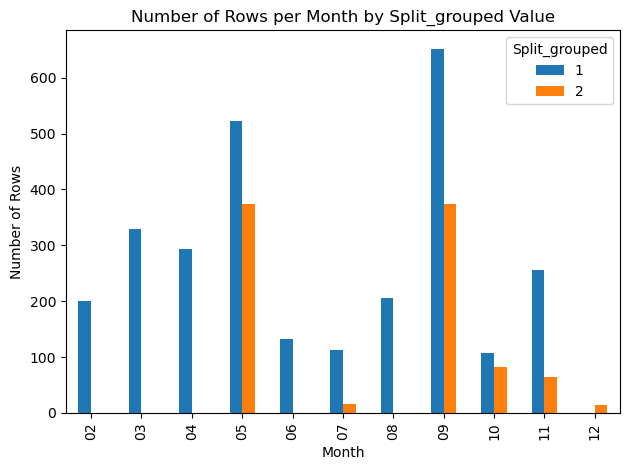

Training: 75.2%  |  Testing: 24.8%


In [5]:
# # Print unique month values grouped by Split value
# for split_val in sorted(training['Split'].unique()):
#     months = sorted(set(pd.to_datetime(training[training['Split'] == split_val]['Date']).dt.strftime('%m')))
#     print(f"Months included in Split {split_val}: {months}")

# # Extract month from 'Date' column
training['Month'] = pd.to_datetime(training['Date']).dt.strftime('%m')

# # Group by 'Month' and 'Split', then count rows
# month_split_counts = training.groupby(['Month', 'Split']).size().unstack(fill_value=0)

# # bar chart
# month_split_counts.plot(kind='bar', stacked=False)
# plt.xlabel('Month')
# plt.ylabel('Number of Rows')
# plt.title('Number of Rows per Month by Split Value')
# plt.legend(title='Split')
# plt.tight_layout()
# plt.show()

# create a new column to test a different test/train split

# Calculate the number of rows for each Date_Loc
date_loc_counts = training['Date_Loc'].value_counts()

# Shuffle the unique Date_Loc values for randomness
unique_date_locs = training['Date_Loc'].unique()
np.random.seed(87)
shuffled_date_locs = np.random.permutation(unique_date_locs)

# Calculate the cumulative sum of rows as we add each Date_Loc
cumulative_counts = date_loc_counts.loc[shuffled_date_locs].cumsum()
# print(f"Cumulative counts: {cumulative_counts}")
total_rows = date_loc_counts.sum()
split_idx = np.argmax(cumulative_counts >= total_rows * 0.7) + 1  # +1 to include the index where threshold is crossed

train_date_locs = set(shuffled_date_locs[:split_idx])
test_date_locs = set(shuffled_date_locs[split_idx:])

# Assign Split_grouped: 1 for train, 2 for test
training['Split_grouped'] = training['Date_Loc'].apply(lambda x: 1 if x in train_date_locs else 2)

# Check distribution across months
month_split_grouped_counts = training.groupby(['Month', 'Split_grouped']).size().unstack(fill_value=0)
month_split_grouped_counts.plot(kind='bar', stacked=False)
plt.xlabel('Month')
plt.ylabel('Number of Rows')
plt.title('Number of Rows per Month by Split_grouped Value')
plt.legend(title='Split_grouped')
plt.tight_layout()
plt.show()

# Print the percentage of points in each split
train_pct = (training['Split_grouped'] == 1).mean() * 100
test_pct = (training['Split_grouped'] == 2).mean() * 100
print(f"Training: {train_pct:.1f}%  |  Testing: {test_pct:.1f}%")

### Load EE data

In [6]:
# California boundary
ca = ee.FeatureCollection("TIGER/2018/States").filter(ee.Filter.equals('NAME', 'California'))
# Agricultural areas from CA DWR's crop maps, 2019 to 2022 inclusive (10m raster)
# crops = ee.Image('projects/ee-annalisertaylor/assets/TNC/agplastics/dwr_allyears')
# Agricultural areas from CA DWR's crop maps, 2019 to 2023 inclusive (10m raster)
crops = ee.Image('projects/ee-tnc-annietaylor/assets/agplastics/dwr_allyears_23')
# socal region for image clipping
socal = ee.FeatureCollection('projects/ee-tnc-annietaylor/assets/agplastics/socal').first()

# County boundaries for spatial filtering 
county_bnd = ee.FeatureCollection("TIGER/2016/Counties").filterBounds(ca)
# make features of the counties you want for filtering/analysis
ventura = county_bnd.filter(ee.Filter.eq('NAME', 'Ventura'))
mendo = county_bnd.filter(ee.Filter.eq('NAME', 'Mendocino'))
cruz = county_bnd.filter(ee.Filter.eq('NAME', 'Santa Cruz'))
santabarbara = county_bnd.filter(ee.Filter.eq('NAME', 'Santa Barbara'))
kern = county_bnd.filter(ee.Filter.eq('NAME', 'Kern'))
humboldt = county_bnd.filter(ee.Filter.eq('NAME', 'Humboldt'))
sanbenito = county_bnd.filter(ee.Filter.eq('NAME', 'San Benito'))
sf = county_bnd.filter(ee.Filter.eq('NAME', 'San Francisco'))
# to read all the county options
# county_df = geemap.ee_to_df(county_bnd)
# pd.set_option('display.max_rows', 75)
# county_df['NAME']

# Encode labels - ee classifier requires numeric class labels
class_mapping = {'hoop': 0, 'mulch': 1, 'other': 2, 'blackmulch': 3}
# only watsonville has greenhouse points right now, santa maria has a separate (unimported) dataset
# but there are no greenhouse points in the cleaned up training dataset
# crops.projection()

## 1. Process Sentinel-2 Imagery

### Cloud filter the image collection

In [7]:
startDate = ee.Date.fromYMD(2010, 1, 1) # setting these to be inclusive for now, can change
endDate = ee.Date.fromYMD(2025, 10, 1)

s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filter(ee.Filter.date(startDate, endDate)) \
    .filter(ee.Filter.bounds(ca)) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 92))  

#### Cloud filtering with the s2_cloudless collection

In [8]:
# cloud mask using the cloudless image collection, pulling from EE documentation example
s2cloud = ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
s2cloud = s2cloud.filterBounds(ca)
MAX_CLOUD_PROBABILITY = 15

def maskClouds(img):
    clouds = ee.Image(img.get('cloud_mask')).select('probability')
    isNotCloud = clouds.lt(MAX_CLOUD_PROBABILITY)
    return img.updateMask(isNotCloud)

# Masks for the 10m bands can include bad data at scene edge; apply masks from the 20m and 60m bands too
def maskEdges(s2_img):
    return s2_img.updateMask(s2_img.select('B8A').mask().updateMask(s2_img.select('B9').mask()))

# So I can investigate how this is performing above plastic cover
def addCloudless(img):
    cloud_prob = ee.Image(img.get('cloud_mask')).select('probability')
    return img.addBands(cloud_prob.rename('cloud_probability'))

# Filter s2cloud to same region, fix 10m pixels at edges
s2_mask = s2.map(maskEdges)

# Join S2 with cloud probability dataset to add cloud mask
# cloudless image is saved as a property called 'cloud_mask' in the original image
s2sr_cloudmask = ee.Join.saveFirst('cloud_mask').apply(primary=s2_mask, secondary=s2cloud, \
                            condition=ee.Filter.equals(leftField='system:index', rightField='system:index'))

# create the cloud masked image collection
s2_cldmsk = ee.ImageCollection(s2sr_cloudmask).map(maskClouds)

# create an image collection with the cloud probability band, not yet masked
# this is for testing to see what values certain pixels have
s2_cld_test = ee.ImageCollection(s2sr_cloudmask).map(addCloudless)

#### Cloud filtering with the QA band 
Checked this out after seeing problems with the s2_cloudless filter, but apparently this band doesn't contain any info from feb 2022 to feb 2024 so it's not usable

In [9]:
def mask_s2_clouds(image):
   qa = image.select('QA60')
   # Bits 10 and 11 are clouds and cirrus, respectively.
   cloud_bit_mask = 1 << 10
   cirrus_bit_mask = 1 << 11
   # Both flags should be set to zero, indicating clear conditions.
   mask = (qa.bitwiseAnd(cloud_bit_mask).eq(0).And(qa.bitwiseAnd(cirrus_bit_mask).eq(0)))
   return image.updateMask(mask)

s2_qa_cldmsk = s2.map(mask_s2_clouds)

#### Cloud filtering with MSK_CLDPRB band

In [10]:
cloud_threshold = 10

def mask_s2_clouds_cm(image):
   cm = image.select('MSK_CLDPRB')
   isNotCloud = cm.lt(MAX_CLOUD_PROBABILITY)
   return image.updateMask(isNotCloud)

s2_cm_cldmsk = s2.map(mask_s2_clouds_cm)

#### Cloud filtering with the SCL band -- this is what we're using

In [11]:
# 8 = Clouds Medium Probability
# 9 = Clouds High Probability
# 10 = Cirrus

def mask_s2_clouds_scl(image):
    scl = image.select('SCL')
    isNotCloud = scl.neq(8).And(scl.neq(9).And(scl.neq(10)))
    return image.updateMask(isNotCloud)

s2_scl_cldmsk = s2.map(mask_s2_clouds_scl)

#### Cloud filtering with google cloud score function
https://courses.spatialthoughts.com/end-to-end-gee.html#batch-exports

In [12]:
# Load the Cloud Score+ collection, now available 2015 onwards
csPlus = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')
csPlusBands = csPlus.first().bandNames() # ['cs', 'cs_cdf']

# join cloud score+ with s2 collection
filteredS2WithCs = s2.linkCollection(csPlus, csPlusBands)

# display('Filtered S2 with CS+ bands:', filteredS2WithCs.first())

# Function to mask pixels with low CS+ QA scores.
def mask_s2_clouds_gcs(image):
  qaBand = 'cs' # probability of clear sky
  clearThreshold = 0.5
  mask = image.select(qaBand).gte(clearThreshold)
  return image.updateMask(mask)

s2_gcs_cldmsk = filteredS2WithCs.map(mask_s2_clouds_gcs)

#### Combined SCL + Cloud Score filters

In [13]:
# Function to mask pixels with low CS+ QA scores and classified as clouds by SCL band
def mask_s2_clouds_combo(image):
  # GCS
  qaBand = 'cs' # probability of clear sky
  clearThreshold = 0.5
  mask = image.select(qaBand).gte(clearThreshold)
  image = image.updateMask(mask)
  # SCL
  scl = image.select('SCL')
  isNotCloud = scl.neq(8).And(scl.neq(9).And(scl.neq(10)))
  return image.updateMask(isNotCloud)

s2_combo_cldmsk = filteredS2WithCs.map(mask_s2_clouds_combo)

### Vis params

In [14]:
rgbVis = {'min': 400, 'max': 1500, 'bands': ['B4', 'B3', 'B2']}
RPGI_viz = {'min': -0.9, 'max': -0.4, 'palette': ['#4d004b', '#f7fcfd']}
NDTI_viz = {'min': 0.0, 'max': 0.2, 'palette': ['white', 'yellow', 'orange']}
# visualize the classified plastic
plastic_viz = {'palette': ['FF5733', 'F4F31D', '2596be', '#333333'], 'min': 0, 'max': 3}
et_viz = {
  'min': 0,
  'max': 100,
  'palette': [
    '9e6212', 'ac7d1d', 'ba9829', 'c8b434', 'd6cf40', 'bed44b', '9fcb51',
    '80c256', '61b95c', '42b062', '45b677', '49bc8d', '4dc2a2', '51c8b8',
    '55cece', '4db4ba', '459aa7', '3d8094', '356681', '2d4c6e',
  ]
}
band_viz = {'min':603, 'max': 2725}
crop_viz = {'palette': ['#FFA500']}
crop_viz2 = {'palette': ["#FFEE00","#FF7300"]}

### Add VIs

In [15]:
def addVIs(image):
    image = image.addBands(image.normalizedDifference(['B8', 'B4']).rename('NDVI'))
    # image = image.addBands(image.normalizedDifference(['B8', 'B12']).rename('NBR')) # one band at 20m
    image = image.addBands(image.normalizedDifference(['B8', 'B11']).rename('NDMI')) # one band at 20m
    image = image.addBands(image.normalizedDifference(['B3', 'B8']).rename('NDWI'))
    # image = image.addBands(image.expression("2.5 * ((b('B8') - b('B4')) / (b('B8') + 6 * b('B4') - 7.5 * b('B2') + 1))").rename('EVI'))
    image = image.addBands(image.normalizedDifference(['B11', 'B12']).rename('NDTI')) # swir1 and swir2, both 20m, tillage index
    image = image.addBands(image.expression("100 * (b('B2') * (b('B8') - b('B4')))/(1 - ((b('B2') + b('B3') + b('B8')) / 3))").rename('PGI')) # all 10m
    image = image.addBands(image.expression("b('B2')/(1 - ((b('B2') + b('B3') + b('B8')) / 3))").rename('RPGI'))
    image = image.addBands(image.normalizedDifference(['B11', 'B4']).rename('PMLI')) # one band at 20m
    image = image.addBands(image.normalizedDifference(['B11', 'B8']).rename('NDBI')) # one band at 20m   
    return image

def adjPGI(image):
    # TODO check if this threshold for NDBI is too high
    # set all bands in the image to 0 where NDVI is higher than 0.73 OR when NDBI is higher than 0.005
    PGI_adj = image.where(image.select('NDVI').gt(0.73), 0)
    PGI_adj = PGI_adj.where(PGI_adj.select('NDBI').gte(0.005), 0)
    # extract the 'PGI' band from that modified image, and add it to the original image with a new name
    image = image.addBands(PGI_adj.select('PGI').rename('PGI_adj'))   
    return image

# not using this right now, keeping it as a useful example for downsampling the NIR band
# will be more precise if we decide to publish any of these data
def addNBR_RS(image):
    # reduces the resolution of the NIR band (10m) to match the SWIR band (20m)
    #   using the mean of all pixels within the larger pixel
    swir = image.select('B12')
    swir_projection = swir.projection()
    nir = image.select('B8').reduceResolution(reducer=ee.Reducer.mean(), maxPixels=16).reproject(crs=swir_projection)
    js_math_exp = 'c = (a-b) / (a+b)'
    js_math_img = ee.Image().expression(
        expression=js_math_exp, opt_map={'a': nir, 'b': swir}
    ).rename('NBR_RS')
    image = image.addBands(js_math_img)
    return image


### Build the collection

In [16]:
# one for each method of cloud filtering, for comparison
# s2_cloudless
processedCollection_cld = s2_cldmsk.map(addVIs)
processedCollection_cld = processedCollection_cld.map(adjPGI)
# scl map
processedCollection_scl = s2_scl_cldmsk.map(addVIs)
processedCollection_scl = processedCollection_scl.map(adjPGI)
# cloud score+ map
processedCollection_gcs = s2_gcs_cldmsk.map(addVIs)
processedCollection_gcs = processedCollection_gcs.map(adjPGI)
# combo cloud score + scl
processedCollection_combo = s2_combo_cldmsk.map(addVIs)
processedCollection_combo = processedCollection_combo.map(adjPGI)
# other cloud masks for testing
processedCollection_qa = s2_qa_cldmsk.map(addVIs)
processedCollection_cm = s2_cm_cldmsk.map(addVIs)

# Choose which cloud filtered collection to use for all analysis
processedCollection = processedCollection_combo

# display(processedCollection)
# print(processedCollection.size().getInfo())
# print(processedCollection.first().bandNames().getInfo())

#### Compare cloud filters

In [17]:
# co = ventura # ventura, mendo, cruz, santabarbara

# images_original = s2.filterBounds(co) #original images

# images_cld = processedCollection_cld.filterBounds(co) # s2 cloudless filter
# images_cloudless = s2_cld_test.filterBounds(co) # get the original image with s2_cloudless probability added - not masked yet
# images_scl = processedCollection_scl.filterBounds(co)
# images_gcs = processedCollection_gcs.filterBounds(co) # gcs cloud filtered
# images_combo = processedCollection_combo.filterBounds(co) # combo cloud filtered
# images_qa = processedCollection_qa.filterBounds(co) # no adjpgi
# images_cm = processedCollection_cm.filterBounds(co) # no adjpgi

# start = '2022-01-16' # sf cloudy image = 2022-01-01?, clouds in santa maria = 2020-09-26 
# end = '2022-01-17'

# original = images_original.filterDate(start, end)#.first()
# original_cloudless = images_cloudless.filterDate(start, end).first()
# cloudless = images_cld.filterDate(start, end).first()
# scl = images_scl.filterDate(start, end)#.first()
# gcs = images_gcs.filterDate(start, end)#.first()
# combo = images_combo.filterDate(start, end)#.first()
# qa = images_qa.filterDate(start, end).first()
# cm = images_cm.filterDate(start, end).first()

# m = geemap.Map()
# m.addLayer(original_cloudless, rgbVis, 'original image + cloudless', False)
# m.addLayer(cloudless, rgbVis, 's2 cloudless', False)
# m.addLayer(scl, rgbVis, 'cloud filtered SCL', False)
# m.addLayer(gcs, rgbVis, 'cloud filtered GCS', False)
# m.addLayer(combo, rgbVis, 'cloud filtered combo', False)
# m.addLayer(qa, rgbVis, 'cloud filtered QA60', False)
# m.addLayer(cm, rgbVis, 'cloud filtered CLDPRB', False)
# m.addLayer(original, rgbVis, 'original image')
# m.centerObject(co, 10)
# m

In [18]:
# Select bands to sample from the sentinel-2 images
bands = [
    'B4', 'B3', 'B2', 'B6', 'B8', 'B11', 'B12',
    'NDVI', 'NDTI', 'PGI', 'RPGI', 'PMLI', 'NDBI', 'PGI_adj', 'NDWI', 'NDMI'
]

#### Match training data dates to clear sentinel-2 images

In [19]:
# matching training data to sentinel images, first clear image on or after the point date
date_matching_wats = {
    'points_date': ['2020-09-26', '2021-09-27', '2022-09-11', '2023-04-12', '2019-11-17', '2023-07-09'],
    'image_date': ['2020-09-26', '2021-10-01', '2022-09-16', '2023-04-14', '2019-12-16', '2023-07-28'],
    'location': ['Watsonville']*6
}
date_matching_mendo = {
    'points_date': ['2021-06-02'],
    'image_date': ['2021-06-06'],
    'location': ['Mendocino']*1
}
date_matching_maria = {
    'points_date': ['2022-08-26', '2023-05-05', '2022-03-10', '2021-02-06'],
    'image_date': ['2022-08-29', '2023-05-11', '2022-03-12', '2021-02-10'],
    'location': ['Santa Maria']*4
}
date_matching_oxnard = {
    # as of 11.13.24, all oxnard dates are added
    # For 5-6-23, can use 5/11 (has clouds but not on those points specifically) or 4/21,
    # cloud free but 15 days prior
    # for 8-1-2023, clouds far from those specific points, take care if adding more points
    'points_date': ['2023-10-17', '2023-05-06', '2023-11-09', '2019-05-17', '2022-06-13',
                    '2021-07-13', '2022-10-01', '2022-11-01', '2019-10-14', '2020-02-15',
                    '2023-08-01', '2021-02-28', '2023-05-07', '2019-08-19', '2023-05-11',
                    '2019-04-01', '2022-09-21', '2018-11-19'],
    'image_date': ['2023-10-28', '2023-05-11', '2023-11-09', '2019-05-17', '2022-06-15',
                   '2021-07-15', '2022-10-03', '2022-11-02', '2019-10-24', '2020-02-16',
                   '2023-08-01', '2021-03-02', '2023-05-06', '2019-08-20', '2023-05-11',
                   '2019-04-02', '2022-09-23', '2018-12-15'],
    'location': ['Oxnard']*18
}

date_matching_other = {
    'points_date': ['2023-05-26', '2023-06-29', #morgan hill
                    '2023-04-27', '2022-03-10', #santa maria
                    '2023-11-09', #oxnard
                    '2023-07-13', '2023-07-08', #santa barbara
                    '2023-08-01', '2022-10-08', '2022-12-23'#maricopa
                    ],
    'image_date': ['2023-06-03', '2023-07-03',
                   '2023-05-11', '2022-03-12',
                   '2023-11-09',
                   '2023-07-15', '2023-07-10',
                   '2023-08-01', '2022-10-08', '2023-01-06'
                   ],

    'location': ['CA']*10
}

# Convert combined dictionary to dataframe
dates_wats = pd.DataFrame.from_dict(date_matching_wats)
dates_mendo = pd.DataFrame.from_dict(date_matching_mendo)
dates_maria = pd.DataFrame.from_dict(date_matching_maria)
dates_oxnard = pd.DataFrame.from_dict(date_matching_oxnard)
dates_other = pd.DataFrame.from_dict(date_matching_other)
# print(dates_wats, '\n', dates_mendo, '\n', dates_maria, '\n', dates_oxnard)

# combine dfs vertically
date_matching = pd.concat([dates_wats, dates_mendo, dates_maria, dates_oxnard, dates_other], axis=0, ignore_index=True)
# print(date_matching.sort_values(by='points_date'))

# This is to check points on the map to get good image matching
# co = cruz # ventura, mendo, cruz, santabarbara

# # option to import points from csv to show them on the map
# watsonville_points = "N:/OCEANS_Program/Plastics/Agricultural_Plastics/Validated Training Data/Watsonville_val_BM.csv"
# oxnard_points = "N:/OCEANS_Program/Plastics/Agricultural_Plastics/Validated Training Data/YYT_RElabeled_points_date_fixed.csv"
# oxnard_points = "N:/OCEANS_Program/Plastics/Agricultural_Plastics/Validated Training Data/oxnard_onedate.csv"

# date = '2018-05-30'
# nextday = ee.Date(date).advance(1, 'day').format('YYYY-MM-dd')
# oneday = processedCollection.filterDate(date, nextday).median()
# oneday_original = s2.filterDate(date, nextday).median()

# first_cruz = ee.Image(processedCollection.filterBounds(co).first())
# display(first_cruz)

# m = geemap.Map()
# # m.add_basemap('HYBRID')
# m.addLayer(oneday_original, rgbVis, 'original image')
# m.addLayer(oneday, rgbVis, 'cloud filtered')
# # m.add_points_from_xy(oxnard_points, x="Longitude", y="Latitude")
# m.centerObject(co, 10)
# # m

##### calculate date gaps for manuscript -- archive

In [20]:
# # Convert columns to datetime format
# date_matching['points_date'] = pd.to_datetime(date_matching['points_date'])
# date_matching['image_date'] = pd.to_datetime(date_matching['image_date'])

# # Calculate the difference in days
# date_matching['days_difference'] = (date_matching['image_date'] - date_matching['points_date']).dt.days

# print(date_matching)
# print(date_matching['days_difference'].describe())

### Evapotranspiration data

In [21]:
et = ee.ImageCollection('OpenET/ENSEMBLE/CONUS/GRIDMET/MONTHLY/v2_0').filterBounds(ca).select('et_ensemble_mad')

# https://developers.google.com/earth-engine/datasets/catalog/OpenET_ENSEMBLE_CONUS_GRIDMET_MONTHLY_v2_0#bands
# Using the ensemble value of ET = 'et_ensemble_mad'

# The ET data only goes through the end of 2024, which is okay with our current training data
# the function will error if we try to sample in 2025 (probably an 'image has no bands' error)

date = ee.Date('2022-07-17')
date = ee.Date(date.format('yyyy-MM-01'))

data = et.filterDate(date, date.advance(1, 'month'))
# display(data)

m = geemap.Map()
m.setCenter(-119.17, 34.19, 6)
m.addLayer(data, et_viz, 'Ensemble ET')
# m

### Satellite embeddings data

In [22]:
embed = ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL').filterBounds(ca)

## Resampling

#### Get the projections of sentinel-2 and ET
These are used later as well 

In [23]:
# ET data doesn't change projection since we don't composite it
# data.first().bandNames()
ET_projection = ee.Image(et.first()).projection() # only one band
# display(ET_projection)

# projection of S2 data is the same before and after processing
# display(processedCollection_combo.first().select('B4').projection().getInfo())
# display(s2.first().select('B4').projection().getInfo())

S2_projection = processedCollection.first().select('B4').projection()
# display(S2_projection)


#### Get S2 and ET data for the same date
This was code to test the workflow, needs to be incorporated below
This is copied from later in the workflow when I'm classifying every S2 image across the water year

In [24]:
wy = 2024
# create dates
stdate = f'{wy}-10-10'
endate = f'{wy}-10-30' # end date is exclusive

# Example coordinates (longitude, latitude)
lon, lat = -119.24912, 34.22826
point = ee.Geometry.Point([lon, lat])

# I want a image for ventura for testing purposes
s2_oneday = processedCollection.filterDate(stdate, endate).filterBounds(point).first().setDefaultProjection(S2_projection)
# display(s2_oneday.select('B12').projection().getInfo())

# then add corresponding ET data for each month
def add_ET(image):
    image_sts = image.get('system:time_start')
    date = image.date()
    et_date = ee.Date(ee.Date(date).format('yyyy-MM-01')) #convert to first of month for ET data
    et_img = et.filterDate(et_date, et_date.advance(1, 'month')).median().rename('ET').setDefaultProjection(ET_projection) # new
    return image.addBands(et_img).set('system:time_start', image_sts)

stacked = add_ET(s2_oneday)

# redundant code to get the et_img to add to map below
image_sts = s2_oneday.get('system:time_start')
date = s2_oneday.date()
et_date = ee.Date(ee.Date(date).format('yyyy-MM-01')) #convert to first of month for ET data
et_img = et.filterDate(et_date, et_date.advance(1, 'month')).median().rename('ET').setDefaultProjection(ET_projection) # new
# et_img


#### Crop mask, sample all to same grid
Using 0.75% coverage of old crop mask to new grid crop mask

In [25]:
# Choose the grid size and projection
gridScale = 30
# CA teale albers = applicable to all CA
gridProjection = ee.Projection('EPSG:3310').atScale(gridScale)
# UTM zone 11 = socal
# gridProjection = ee.Projection('EPSG:32611').atScale(gridScale)

# Set the resampling mode
# stacked = stacked.resample('bilinear')

# Aggregate pixels with 'mean' statistics
stackedResampled = stacked.reduceResolution(
  reducer = ee.Reducer.mean(),
  maxPixels = 1024
).reproject(
    crs = gridProjection
)

# unmask(0) replaces all masked (None) pixels with 0 so i can use min reducer
filled = crops.unmask(0)

# Convert all non-zero values to 1
binary_crop = filled.gt(0)  # gt(0) returns 1 if >0, else 0

cropsResampled = binary_crop.reduceResolution(ee.Reducer.mean()).reproject(crs = gridProjection)

# if you reduce by mean, values are the percentage of crop cover in the larger pixel
# testing a good threshold to filter out roads etc. 
cropsResampled = cropsResampled.gt(0.75)

m = geemap.Map()
m.add_basemap('SATELLITE')
m.centerObject(stackedResampled, 10)

m.addLayer(stackedResampled.select(['B4', 'B3', 'B2']), rgbVis, 'resamp S2', False)
m.addLayer(s2_oneday, rgbVis, 'old S2', False)
m.addLayer(stackedResampled.select(['B4', 'B3', 'B2']).mask(crops), rgbVis, 'old mask s2', False)
m.addLayer(stackedResampled.select(['B4', 'B3', 'B2']).mask(cropsResampled), rgbVis, 'new mask s2')
m.addLayer(cropsResampled.mask(cropsResampled), crop_viz, 'resamp crops', True)
m.addLayer(crops, crop_viz2, 'old crops', False)
# m.addLayer(stackedResampled.select('ET'), et_viz, 'resamp ET')
# m.addLayer(et_img, et_viz, 'old ET')
# m

In [27]:
# export crop mask to tif on drive for use in rivers/buffer analysis
task_file = ee.batch.Export.image.toDrive(
    image=cropsResampled.toByte(),
    description='CA_cropmask_30m',
    folder='EarthEngine',
    fileNamePrefix='CA_cropmask_30m',
    region=ca.geometry(),
    scale=30,
    crs='EPSG:3310',
    maxPixels=1e13
)

task_file.start()

# export crop mask to asset
task_asset = ee.batch.Export.image.toAsset(
    image=cropsResampled.toByte(),
    description='CA_cropmask_30m_asset',
    assetId='projects/ee-tnc-annietaylor/assets/agplastics/CA_cropmask_30m',
    region=ca.geometry(),
    scale=30,
    crs='EPSG:3310',
    maxPixels=1e13
)

# task_asset.start()

#### compare resolutions of the three bands

In [ ]:
date = '2022-03-12'
nextday = ee.Date(date).advance(1, 'day').format('YYYY-MM-dd')
oneday = processedCollection.filterDate(date, nextday).median()
# oneday_original = s2.filterDate(date, nextday).median()

m = geemap.Map()
m.setCenter(-119.17, 34.19, 6)
m.addLayer(data, et_viz, 'Ensemble ET')
m.addLayer(oneday.select('B12'), band_viz, 'B12') # SWIR2, 20m
m.addLayer(oneday.select('B8'), band_viz, 'B8') # NIR, 10m
# m

# print(processedCollection_scl.first().select('B8').projection().getInfo())
# print(processedCollection_scl.first().select('B12').projection().nominalScale().getInfo())
# data.first().projection()



#### archive code that didn't work to resample

In [ ]:
# test = ee.Image(processedCollection_scl.first())

# et_image = et.first()
# et_proj = et_image.projection()
# et_crs = et_proj.crs().getInfo()
# et_transform = et_image.projection().getInfo()['transform']
# et_transform = et_proj.transform().getInfo()  # This must be a list of 6 floats

# Confirm it's a list of 6 floats
# print("ET transform:", et_transform)
# print("ET CRS:", et_crs)

# s2_projection_10m = test.select('B8').projection()
# s2_projection_20m = test.select('B12').projection()

# s2_resampled_10m = (
#     test.setDefaultProjection(s2_projection_10m)
#     .reduceResolution(reducer=ee.Reducer.mean(), maxPixels=1024)
#     .reproject(crs=et_crs, crsTransform=et_transform)
# )

# s2_resampled_20m = (
#     test.setDefaultProjection(s2_projection_20m)
#     .reduceResolution(reducer=ee.Reducer.mean(), maxPixels=1024)
#     .reproject(crs=et_crs, crsTransform=et_transform)
# )

In [ ]:
# # convert the sentinel image to the same projection as the ET data
# test = ee.Image(processedCollection_scl.first())

# et_projection = et.first().projection()
# et_transform = et_image.projection().getInfo()['transform']
# et_crs = et_projection.crs().getInfo()
# s2_projection_10m = test.select('B8').projection() #this is the projection of the 10m band
# s2_projection_20m = test.select('B12').projection() # this is the projection of the 20m band

# # print('ET projection:', et_projection.getInfo())
# # print('S2 projection 10m:', s2_projection_10m.getInfo())  
# # print('S2 projection 20m:', s2_projection_20m.getInfo())  

# s2_resampled_10m = (
#     test.setDefaultProjection(s2_projection_10m)
#     # Force the next reprojection to aggregate instead of resampling
#     .reduceResolution(reducer=ee.Reducer.mean())
#     # Request the data at the scale and projection of the ET image
#     .reproject(crs=et_crs, crsTransform=et_transform)
# )

# s2_resampled_20m = (
#     test.setDefaultProjection(s2_projection_20m)
#     # Force the next reprojection to aggregate instead of resampling
#     .reduceResolution(reducer=ee.Reducer.mean())
#     # Request the data at the scale and projection of the ET image
#     .reproject(crs=et_crs, crsTransform=et_transform)
# )

# # print('Resampled 10m band projection:', s2_resampled_10m.select('B8').projection().getInfo())
# # print('Resampled 20m band projection:', s2_resampled_20m.select('B12').projection().getInfo())

# m = geemap.Map()
# m.setCenter(-119.17, 34.19, 6)
# m.centerObject(test, 10)
# m.addLayer(data, et_viz, 'Ensemble ET')
# # m.addLayer(oneday.select('B12'), band_viz, 'B12', False) # SWIR2, 20m
# # m.addLayer(oneday.select('B8'), band_viz, 'B8', False) # NIR, 10m
# m.addLayer(test.select('B12'), band_viz, 'B12 original') # SWIR, 20m
# m.addLayer(test.select('B8'), band_viz, 'B8 original') # NIR, 10m
# m.addLayer(s2_resampled_10m.select('B8'), band_viz, 'resampled 10m') #NIR, 30m
# m.addLayer(s2_resampled_20m.select('B12'), band_viz, 'resampled 20m') #SWIR, 30m
# m.addLayer(s2_resampled_20m_2.select('B12'), band_viz, 'resampled 20m method 2') #SWIR, 30m
# # m

## 2. Sample to new training dataset

Add matching sentinel image date to training dataset points

In [ ]:
# training is my df of points with lat/longs, type label, date of high res image, and location 
# date_matching_loc matches the training points by date and location to the sentinel images

# display(training.shape[0])

# Ensure 'Date' in training is in YYYY-MM-DD format for matching
training['Date'] = pd.to_datetime(training['Date']).dt.strftime('%Y-%m-%d')

# Copy date_matching and convert 'points_date' to YMD format for matching
date_matching_loc = date_matching.copy()
date_matching_loc['points_date'] = pd.to_datetime(date_matching_loc['points_date']).dt.strftime('%Y-%m-%d')

# Merge on both 'Date' (training) <-> 'points_date' and 'Location' <-> 'location'
training_merged = training.merge(
    date_matching_loc[['points_date', 'location', 'image_date']],
    left_on=['Date', 'Location'],
    right_on=['points_date', 'location'],
    how='left'
)

# format image_date to YYYY-MM-DD
training_merged['image_date'] = pd.to_datetime(training_merged['image_date']).dt.strftime('%Y-%m-%d')

# Now training['image_date'] contains the matched image date for each point
display(training_merged.head())

# print unique date_loc values
# print('Unique date/location pairs in training data:', training_merged['Date_Loc'].unique())

# cut out region column
training_merged = training_merged.drop(columns=['Region'])

# check if training_merged has any NaN values
# print('NaN values:', training_merged.isnull().sum())

# # which date_loc pairs have nan values for image_date?
# nan_image_dates = training_merged[training_merged['image_date'].isnull()][['Date', 'Location']]
# print('Date/Location pairs with no matching image date:')
# print(nan_image_dates)

# filter training_merged to only include rows with non-null image_date
# training_merged = training_merged[training_merged['image_date'].notnull()]
# print the number of rows in training_merged
print('Number of rows in training_merged after filtering:', training_merged.shape[0])


In [ ]:
def sample_dates(df):
    # add a 'class' column to the df by mapping the 'Type' column to numeric values
    df['class'] = df['Type'].map(class_mapping)

    date_locations = df['Date_Loc'].unique()

    all_area_data = []

    # Iterate through all of the dates in the df
    for dl in date_locations:
        # Get df rows for that date/location pair
        df_dateloc = df[df['Date_Loc'] == dl]
        
        # print(f"DF: {len(df_dateloc)} rows for date/location: {dl}") # test

        fc_date = geemap.df_to_ee(df_dateloc, latitude='Latitude', longitude='Longitude')

        # print('FC:', fc_date.size().getInfo()) # test

        # Get properties for this date/location pair
        date = df_dateloc['Date'].iloc[0]
        image_date = df_dateloc['image_date'].iloc[0]
        location = df_dateloc['Location'].iloc[0]
        # Filter images to only that one corresponding sampling date
        image_nextdate = ee.Date(image_date).advance(1, 'day').format('YYYY-MM-dd')
        sample_image = processedCollection.filterDate(image_date, image_nextdate).median()
        # Sample that image to the fc, keeping ‘class’ property
        data = sample_image.select(bands).sampleRegions(
            collection=fc_date,
            properties=['class', 'Latitude', 'Longitude', 'Split', 'Split_grouped'],
            scale=10, #Reduces points within 10m of each other, should not be any
            geometries=True
        )

        # print('S2 sampled FC:', data.size().getInfo()) # test

        # Also sample the monthly ET (30m scale, from landsat and other weather data)
        et_date = ee.Date(ee.Date(image_date).format('yyyy-MM-01')) #convert to first of month for ET data
        et_img = et.filterDate(et_date, et_date.advance(1, 'month')).median().rename('ET')
        data = et_img.sampleRegions(
            collection=data,
            scale=30, #Reduces points within 30m of each other, should not be any
            geometries=True
            # keep all properties from sampling points
        )

        # print('ET sampled FC:', data.size().getInfo()) # test

        # sample from the satellite embedding dataset from alphaearth
        # Get just the year of the image_date
        embed_year = ee.Date(ee.Date(image_date).format('yyyy-01-01'))
        embed_img = embed.filterDate(embed_year, embed_year.advance(1, 'year')).mosaic()
        data = embed_img.sampleRegions(
            collection=data,
            scale=10,
            geometries=True
        )

        # Add point date, sampled image date, and location as a property to each feature in the feature collection
        data = data.map(lambda feature: feature.set({
            'date': date,
            'image_date': image_date,
            'location': location
            }))
        
        # Append to list of fcs for each date/location pair
        all_area_data.append(data)

    # Flatten into one fc for the dataset
    area_fc = ee.FeatureCollection(all_area_data).flatten()

    # print('Total resulting features:', area_fc.size().getInfo()) # test

    return area_fc

##### Testing
# # Filter to two unique Date_Loc pairs for testing
# two_pairs = training_merged['Date_Loc'].unique()[10:17]
# training_merged_subset = training_merged[training_merged['Date_Loc'].isin(two_pairs)]

# training_merged_subset_sampled = sample_dates(training_merged_subset)
# training_merged_subset_sampled

# # convert that to dataframe
# training_merged_subset_sampled_df = geemap.ee_to_df(training_merged_subset_sampled)
# training_merged_subset_sampled_df.head()

#### Full sampling
# Sample the training data for all dates/locations
training_merged_sampled = sample_dates(training_merged)
# print(training_merged_sampled.size().getInfo())

# sample = training_merged_sampled.limit(5)
# sample


#### calculate day gaps for manuscript
not archive, but not used right now

In [ ]:
# # Convert columns to datetime format
# training_merged['points_date'] = pd.to_datetime(training_merged['points_date'])
# training_merged['image_date'] = pd.to_datetime(training_merged['image_date'])

# # Calculate the difference in days
# training_merged['days_difference'] = (training_merged['image_date'] - training_merged['points_date']).dt.days
# # print(training_merged)
# display(training_merged['days_difference'].describe())

# unique_date_pairs = training_merged[['points_date', 'image_date']].drop_duplicates().sort_values(by=['points_date'])
# # display(unique_date_pairs.reset_index(drop=True))

# # Calculate the difference in days
# unique_date_pairs['days_difference'] = (unique_date_pairs['image_date'] - unique_date_pairs['points_date']).dt.days
# display(unique_date_pairs.sort_values(by='days_difference'))

#### testing satellite embeddings sampling

In [ ]:
# df = training_merged
# dl = training_merged['Date_Loc'].unique()[10]
# print('Sampling for date/location:', dl)

# df_dateloc = df[df['Date_Loc'] == dl]
# # df_dateloc.head()
# # Get properties for this date/location pair
# # date = df_dateloc['Date'].iloc[0]
# image_date = df_dateloc['image_date'].iloc[0]

# print(f"DF: {len(df_dateloc)} rows for date/location: {dl}") # test

# fc_date = geemap.df_to_ee(df_dateloc, latitude='Latitude', longitude='Longitude')

# print('FC:', fc_date.size().getInfo()) # test

# embed_year = ee.Date(ee.Date(image_date).format('yyyy-01-01'))
# embed_year

# embed_img = embed.filterDate(embed_year, embed_year.advance(1, 'year')).mosaic()

# data = embed_img.sampleRegions(
#     collection=fc_date,
#     scale=10,
#     geometries=True
# )

# # embed_img
# # Convert that to dataframe
# data_df = geemap.ee_to_df(data)
# data_df.head()

#### Old method: sample each feature collection to build training dataset -- archive
This method uses image matching to ensure there are no cloudy pixels in the training data

this is for the old training dataset

Skip to 2b for faster running code if you haven't made changes to imagery / sampling methods

In [ ]:
# def sample_dates(df):
#     # add a 'class' column to the df by mapping the 'Type' column to numeric values
#     df['class'] = df['Type'].map(class_mapping)
#     # Format dates to YYYY-MM-DD
#     df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')

#     # print('pre-filter', df['Date'].unique())
#     # print(df.shape[0])

#     # Drop greenhouse, drop points from before 2018-05-09
#     df = df[df["Type"]!="greenhouse"]
#     df = df[df['Date'] > '2018-05-09']
#     # print('post-filter', df['Date'].unique())
#     # print(df.shape[0])
    
#     # get the location of the df to be sampled
#     location = df['Location'].iloc[0]
#     # filter the date_matching df to this location
#     date_matching_loc = date_matching[date_matching['location'] == location]
#     # Filter for only dates that have a matched sampling image, should be all now
#     df = df.loc[df['Date'].isin(date_matching_loc['points_date'])]

#     dates = df['Date'].unique()
#     # print('post-filter', dates)

#     all_area_data = []

#     # Iterate through all of the dates in the df
#     for date in dates:
#         # Get df rows for that date
#         df_date = df[df["Date"]==date]
#         fc_date = geemap.df_to_ee(df_date, latitude='Latitude', longitude='Longitude')
#         # Get image date from the date_matching df
#         image_date = date_matching_loc.loc[date_matching_loc['points_date'] == date, 'image_date'].iloc[0]
#         # Filter images to only that one corresponding sampling date
#         image_nextdate = ee.Date(image_date).advance(1, 'day').format('YYYY-MM-dd')
#         sample_image = processedCollection.filterDate(image_date, image_nextdate).median()
#         # Sample that image to the fc, keeping ‘class’ property
#         data = sample_image.select(bands).sampleRegions(
#             collection=fc_date,
#             properties=['class', 'Latitude', 'Longitude'],
#             scale=10, #Reduces points within 10m of each other
#             geometries=True
#         )

#         # Also sample the monthly ET (30m scale, from landsat and other weather data)
#         et_date = ee.Date(ee.Date(image_date).format('yyyy-MM-01')) #convert to first of month for ET data
#         et_img = et.filterDate(et_date, et_date.advance(1, 'month')).median().rename('ET')
#         data = et_img.sampleRegions(
#             collection=data,
#             scale=30, #I believe 30m scale reduces points within 30m of each other
#             geometries=True
#         )
#         # Add point date, sampled image date, and location as a property to each feature in the feature collection
#         data = data.map(lambda feature: feature.set({
#             'date': date,
#             'image_date': image_date,
#             'location': location
#             }))

#         # Append to list of fcs for each date
#         all_area_data.append(data)

#     # Flatten into one fc for the dataset
#     area_fc = ee.FeatureCollection(all_area_data).flatten()
#     return area_fc

In [ ]:
# test = sample_dates(othertrees)
# print(test.size().getInfo())
# test_df = geemap.ee_to_df(test)
# test_df
# filtered = date_matching[date_matching['location'] == 'Oxnard']
# print(filtered)
# display('after sampling', test_df['class'].value_counts())
# display('before sampling', oxnard['Type'].value_counts())
# print(class_mapping)

# make a df with manually entered points
# but you would also have to add to date_matching for any new image dates
# data_points = [
#     ['Oxnard', '8/1/2023', 'mulch', -119.257339, 34.260933]
# ]
# other_points = pd.DataFrame(data_points, columns=['Location', 'Date', 'Type', 'Longitude', 'Latitude'])
# test

# santamaria printout says 298, excel file is 768. total rows matches. my filtering function is 768.
# mendo is right (none)
# watsonville printout says 65, excel file is 464. total rows matches. my filtering function is 464 (accounting for greenhouse points)
# oxnard printout says 578, excel files (2) are 0. total rows 1474 + 59 = 1533 matches. my filtering function is 1533.
# so all of the filtering is working as I expect

In [ ]:
# # On 9.20.24, removed mendocino training data from the model 
# # mendo_training = sample_dates(mendocino)
# watsonville_training = sample_dates(watsonville)
# santamaria_training = sample_dates(santamaria)
# oxnard_training = sample_dates(oxnard)
# # On 1.30.25 added other trees dataset
# othertrees_training = sample_dates(othertrees)

# # Combine all data - list of feature collections
# all_data = []
# # all_data.append(mendo_training)
# all_data.append(watsonville_training)
# all_data.append(santamaria_training)
# all_data.append(oxnard_training)
# all_data.append(othertrees_training)

# # generate a random number column for training/test split
# data = ee.FeatureCollection(all_data).flatten().randomColumn(seed=0)

In [ ]:
# # save the fc as an asset to drastically speed up later anaylsis
# # have to delete this asset first, can't overwrite it

data = training_merged_sampled
asset_id = 'projects/ee-tnc-annietaylor/assets/agplastics/training_v_1_2_s87'
task = ee.batch.Export.table.toAsset(
    collection=data,
    description='Export training data to asset',
    assetId=asset_id
)
# task.start()

## 2b Import training data as fc instead of building it

In [ ]:
# import the fc with training data prepped for each version of the model
# asset_id = 'projects/ee-tnc-annietaylor/assets/agplastics/labeled_point_data_matched_ET_BM_o_nm_ox_all' #v0.9
# asset_id = 'projects/ee-tnc-annietaylor/assets/agplastics/labeled_point_data_matched_ET_BM_o_nm_ox_all_trees' #v1.0
# asset_id = 'projects/ee-tnc-annietaylor/assets/agplastics/labeled_point_data_matched_ET_BM_o_nm_ox_all_trees_pgi' #v1.1
asset_id = 'projects/ee-tnc-annietaylor/assets/agplastics/training_v_1_2_s87' #v1.2
# asset_id = 'projects/ee-tnc-annietaylor/assets/agplastics/training_v_1_2_embed' #v1.2 + satellite embeddings dataset

data = ee.FeatureCollection(asset_id)

### 2c violin plots

In [ ]:
data_df = geemap.ee_to_df(data)
class_mapping_reversed = {v: k for k, v in class_mapping.items()}
data_df['Type'] = data_df['class'].map(class_mapping_reversed)
data_df.head()

In [ ]:
# select the band of interest for plotting
boi = "NDTI"
# NDTI, ET, RPGI, B12, NDVI, NDMI, B11, PGI, B6, NDBI, B2, NDWI

In [ ]:
chart = alt.Chart(data_df).mark_boxplot().encode(
    alt.X("Type:N", sort=['other', 'hoop', 'mulch', 'blackmulch']),
    alt.Y(boi).scale(zero=False),
    alt.Color("Type:N"),
    alt.Tooltip("image_date:T")
).properties(width=300)

countlabel = alt.Chart(data_df).mark_text(align='center', dy=-130, fontWeight=100, fontSize=10).encode(
    x='Type:N',
    text='label:N'
).transform_joinaggregate(
    n_count = 'count(Type)',
    groupby=['Type']
).transform_calculate(
    label = "'n = ' + datum.n_count"
)

# chart + countlabel

In [ ]:
chart2 = alt.Chart(data_df, width=100).transform_density(
    boi,
    as_=[boi, 'density'],
    groupby=['Type']
).mark_area(orient='horizontal').encode(
    alt.X('density:Q')
        .stack('center')
        .impute(None)
        .title(None)
        .axis(labels=False, values=[0], grid=False, ticks=True),
    alt.Y(boi),
    alt.Color('Type:N'),
    alt.Column('Type:N', sort=['other', 'hoop', 'mulch', 'blackmulch'])
        .spacing(0)
        .header(titleOrient='bottom', labelOrient='bottom', labelPadding=0)
).configure_view(
    stroke=None
)

# chart2
display(chart + countlabel, chart2)

## 3. Split training and test data

#### merge blackmulch class into mulch class
Slightly higher overall accuracy and higher recall (aka fewer mulch points missed)

In [ ]:
# combine black mulch and mulch classes as this slightly improved model performance
# data.first().get('class').getInfo()
data = data.map(lambda feature: feature.set('class', ee.Algorithms.If(ee.Number(feature.get('class')).eq(3), 1, feature.get('class'))))

In [ ]:
# Process data (1): Train test split
# print(f"Total number of labeled data:", data.size().getInfo())
# split = 0.7
# training = data.filter(ee.Filter.lt('random', split))
# test = data.filter(ee.Filter.gte('random', split))

# new way -- training/test split is set based on the 'Split' field
# training = data.filter(ee.Filter.eq('Split', 1))
# test = data.filter(ee.Filter.eq('Split', 2))

# new way TEST NEW SPLIT -- training/test split is set based on the 'Split_grouped' field
training = data.filter(ee.Filter.eq('Split_grouped', 1))
test = data.filter(ee.Filter.eq('Split_grouped', 2))

print(f"Number of training points: {training.size().getInfo()}")
print(f"Number of test points: {test.size().getInfo()}")

#### Training data stats

In [ ]:
# convert to dfs for easier stats
# training_df = geemap.ee_to_df(training)
# test_df = geemap.ee_to_df(test)

# print(f"Number of training points: {training_df.shape[0]}")
# print(f"Number of test points: {test_df.shape[0]}")

# Check number of data in each location
# print("Number of training points:", training_df['location'].value_counts())
# print("Number of test points:", test_df['location'].value_counts())

#### Address spatial autocorrelation (archive)
- Remove points within 30 meters of each other between the training and test datasets
- DOES NOT ADDRESS SPATIAL AUTOCORRELATION W/IN THESE DATASETS and also the fact that many of these points are from different dates :/ 
- not using this with new training dataset as of 8/7/25

In [ ]:
# # Process data (2): Address autocorrelation correction
# # TODO how are we addressing spatial autocorrelation within each dataset?
# # right now this is simply removing any training data points within 30m of a test point
# distFilter = ee.Filter.withinDistance(
#     distance=30,
#     leftField='.geo',
#     rightField='.geo',
#     maxError=10
# )
# join = ee.Join.inverted()
# training = join.apply(training, test, distFilter)
# # print(f"Number of training points after removing autocorrelation: {training.size().getInfo()}")


# # only need to worry about this within dates, within the same week for example
# # if val point is too close to training point, we're not actually testing our model
# # should we validate points from new fields -- this is kirk's preference
# # use lat long and time to cluster points, break this into n groups
# #  wihtin this time period, 
# # geographic clusters per year and per region
# # or i could set a max number of points per cluster

In [ ]:
# convert to dfs for easier stats again
training_df = geemap.ee_to_df(data)
# Check number of training data in each region again
display("Number of reference points:", training_df['location'].value_counts())
display('number of points test/training:', training_df['Split_grouped'].value_counts())
# training_df.head(5)
# training

In [ ]:
# print("Number of training points of each class:", training_df['class'].value_counts())
for class_name, class_id in class_mapping.items():
   filtered_df = training_df[training_df['class'] == class_id]
   print(f"Number of points labeled {class_name}: {filtered_df.shape[0]}")

## 4. Train and Evaluate Models

### Random Forest
Specify bands to train the model on

In [ ]:
# if  using satellite embeddings
# bands_tr = [
#     'B4', 'B3', 'B2', 'B6', 'B8', 'B11', 'B12',
#     'NDVI', 'NDTI', 'PGI', 'RPGI', 'PMLI', 'NDBI', 'PGI_adj', 'NDWI', 'NDMI', 'ET',
#     'A00', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A10',
#     'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21',
#     'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32',
#     'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A40', 'A41', 'A42', 'A43',
#     'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A50', 'A51', 'A52', 'A53', 'A54',
#     'A55', 'A56', 'A57', 'A58', 'A59', 'A60', 'A61', 'A62', 'A63'
# ]

# bands not using satellite embeddings
bands_tr = [
    'B4', 'B3', 'B2', 'B6', 'B8', 'B11', 'B12',
    'NDVI', 'NDTI', 'PGI', 'RPGI', 'PMLI', 'NDBI', 'PGI_adj', 'NDWI', 'NDMI', 'ET'
]

In [ ]:
# Train and test the RF model
trained_RF = ee.Classifier.smileRandomForest(50).train(training, 'class', bands_tr)
trainAccuracy_RF = trained_RF.confusionMatrix()

classifications_RF = test.classify(trained_RF)
testAccuracy_RF = classifications_RF.errorMatrix('class', 'classification')

# print out accuracy information
print(f"Training accuracy: {trainAccuracy_RF.accuracy().getInfo()*100:.2f}%")
print(f"Test accuracy: {testAccuracy_RF.accuracy().getInfo()*100:.2f}%")
# trained_RF.explain()
# takes about 2 min to run if you have recreated instead of importing the training data, otherwise super fast
# classifications_RF

In [ ]:
# this gives f score for each class (hoop, mulch, other) (blackmulch combined now)
classacc = testAccuracy_RF.fscore().getInfo()
print(f'hoop: {classacc[0]*100:.2f}%')
print(f'mulch: {classacc[1]*100:.2f}%')
print(f'other: {classacc[2]*100:.2f}%')

#### Confusion matrices

In [ ]:
# Plot confusion matrix
# display_labels = ['hoop', 'mulch', 'other', 'blackmulch']
display_labels = ['hoop', 'mulch', 'other']

cm_RF = np.array(testAccuracy_RF.getInfo())
disp = ConfusionMatrixDisplay(confusion_matrix=cm_RF, display_labels=display_labels)
disp.plot(cmap=plt.cm.Greys)
disp.ax_.set_title(f"RF Confusion Matrix ({testAccuracy_RF.accuracy().getInfo():.2%} Accuracy)")

#### Variable Importances

In [ ]:
importance = ee.Dictionary(trained_RF.explain().get('importance'))

totalImportance = importance.values().reduce(ee.Reducer.sum())

# helper fn to map over importance values
def percentConvert(key, val):
    return ee.Number(val).divide(totalImportance).multiply(100)
relImportance = importance.map(percentConvert)

importanceFC = ee.FeatureCollection([ee.Feature(None, relImportance)])
# convert to pandas df
varImportance = geemap.ee_to_df(importanceFC)

varImportance = varImportance.transpose().rename(columns={0: 'Importance'})
varImportance = varImportance.sort_values(by='Importance', ascending=False)
varImportance

# varImportance.plot(kind='bar')
# plt.show()

#### Reproducible/condensed version
Used for debugging, this is fairly old now

In [ ]:
# # Reproducible version to test errors
# # import the training data - points labeled with class (0, 1, 2) and containing sampled band info
# asset_id = 'projects/ee-annalisertaylor/assets/TNC/agplastics/labeled_point_data' # needs to be read-only/public
# data = ee.FeatureCollection(asset_id)
# # subset the training data by approx 70% for training (and 30% for testing)
# training = data.filter(ee.Filter.lt('random', 0.7))
# bands = ['B4', 'B3', 'B2', 'B6', 'B8', 'B11', 'B12', 'NDVI', 'NDTI', 'PGI', 'RPGI', 'PMLI']

# trained_RF = ee.Classifier.smileRandomForest(50).train(training, 'class', bands)

# importance = ee.Dictionary(trained_RF.explain().get('importance'))

# totalImportance = importance.values().reduce(ee.Reducer.sum())

# # helper fn to map over importance values
# def percentConvert(key, val):
#     return ee.Number(val).divide(totalImportance).multiply(100)
# relImportance = importance.map(percentConvert)

# importanceFC = ee.FeatureCollection([ee.Feature(None, relImportance)])
# # convert to pandas df
# varImportance = geemap.ee_to_df(importanceFC)
# varImportance

### Testing different random seeds for test/train split
trying to maximize overall testing accuracy but also mulch accuracy
random seed 87 looks great

In [ ]:
# # import data just after sampling to s2 images and reset black mulch 
# data = training_merged_sampled
# data = data.map(lambda feature: feature.set('class', ee.Algorithms.If(ee.Number(feature.get('class')).eq(3), 1, feature.get('class'))))

# # convert data fc to df
# data_df = geemap.ee_to_df(data)
# # add a Date_Loc field that's date + location fields
# data_df['Date_Loc'] = data_df['date'] + data_df['location']

# # display(data_df)

# # function to try different seeds for splits
# def split_data(seed):
#     # import unique date_loc info from training data that was df (before sampling to fc)
#     date_loc_counts = data_df['Date_Loc'].value_counts()
#     unique_date_locs = data_df['Date_Loc'].unique()
#     # Shuffle the unique Date_Loc values for randomness
#     np.random.seed(seed)
#     shuffled_date_locs = np.random.permutation(unique_date_locs)

#     # Calculate the cumulative sum of rows as we add each Date_Loc
#     cumulative_counts = date_loc_counts.loc[shuffled_date_locs].cumsum()
#     # print(f"Cumulative counts: {cumulative_counts}")
#     total_rows = date_loc_counts.sum()
#     split_idx = np.argmax(cumulative_counts >= total_rows * 0.7) + 1  # +1 to include the index where threshold is crossed

#     train_date_locs = set(shuffled_date_locs[:split_idx])
#     test_date_locs = set(shuffled_date_locs[split_idx:])

#     # Assign Split_grouped field: 1 for train, 2 for test
#     split_col = f'Split_grouped_seed{seed}'
#     data_df[split_col] = data_df['Date_Loc'].apply(lambda x: 1 if x in train_date_locs else 2)

#     # # Check distribution across months
#     # month_split_grouped_counts = data_df.groupby(['Month', 'Split_grouped']).size().unstack(fill_value=0)
#     # month_split_grouped_counts.plot(kind='bar', stacked=False)
#     # plt.xlabel('Month')
#     # plt.ylabel('Number of Rows')
#     # plt.title('Number of Rows per Month by Split_grouped Value')
#     # plt.legend(title='Split_grouped')
#     # plt.tight_layout()
#     # plt.show()

#     # # Print the percentage of points in each split
#     # train_pct = (data_df['Split_grouped'] == 1).mean() * 100
#     # test_pct = (data_df['Split_grouped'] == 2).mean() * 100
#     # print(f"Training: {train_pct:.1f}%  |  Testing: {test_pct:.1f}%")

#     # convert back to fc from df, no geometries
#     features = []
#     for _, row in data_df.iterrows():
#         props = row.to_dict()
#         features.append(ee.Feature(None, props))
#     data = ee.FeatureCollection(features)

#     # split it into test/train based on that seed
#     training = data.filter(ee.Filter.eq(split_col, 1))
#     test = data.filter(ee.Filter.eq(split_col, 2))

#     # print(f"Number of training points: {training.size().getInfo()}")
#     # print(f"Number of test points: {test.size().getInfo()}")

#     # build and test model
#     trained_RF = ee.Classifier.smileRandomForest(50).train(training, 'class', bands_tr)
#     trainAccuracy_RF = trained_RF.confusionMatrix()

#     classifications_RF = test.classify(trained_RF)
#     testAccuracy_RF = classifications_RF.errorMatrix('class', 'classification')

#     # save accuracy information to a df 
#     accuracy_info = {
#         "Seed": seed,
#         "Training accuracy": trainAccuracy_RF.accuracy().getInfo(),
#         "Test accuracy": testAccuracy_RF.accuracy().getInfo(),
#         "Test F-score": testAccuracy_RF.fscore().getInfo()
#     }
#     return accuracy_info

# dfs = []
# for seed in [10, 15, 87, 23, 54, 53, 88, 86, 31, 66]:
#     accuracy_info = split_data(seed)
#     dfs.append(accuracy_info)

# dfs = pd.DataFrame(dfs)
# display(dfs)
# # ran two seeds in 3 min
# # ran ten seeds in 7 min


## 5. Export the model

per [ee docs](https://developers.google.com/earth-engine/apidocs/export-classifier-toasset#colab-python), allows you to build larger models (i.e. more trees, more training samples)

In [ ]:
rf_asset_id = 'projects/ee-tnc-annietaylor/assets/agplastics/RF_classifier_v_1_2_s87'
task = ee.batch.Export.classifier.toAsset(
    classifier=trained_RF,
    description='classifier_export',
    assetId=rf_asset_id
)
# task.start()

## 6. Apply standard classification model to imagery

In [ ]:
# bring in the saved classifiers
rf_asset_id_v1_1 = 'projects/ee-tnc-annietaylor/assets/agplastics/RF_classifier_matched_ET_BM_o_nm_ox_all_trees_pgi'
rf_asset_id = 'projects/ee-tnc-annietaylor/assets/agplastics/RF_classifier_v_1_2_s87'
rf_asset_id_e = 'projects/ee-tnc-annietaylor/assets/agplastics/RF_classifier_v_1_2_embed'
savedClassifier_v1_1 = ee.Classifier.load(rf_asset_id_v1_1)
savedClassifier = ee.Classifier.load(rf_asset_id)
savedClassifier_e = ee.Classifier.load(rf_asset_id_e)

#### Get all images from one date, stitch them together, and center the map on that

In [ ]:
# for a given date, get images from that date, stitch them together, and center the map on that
# great image to check: '2024-10-02', earth image date 9/30/2024 in Oxnard area: 
# https://earth.google.com/web/@34.22849791,-119.2434538,6.54306045a,5617.78356609d,35y,0h,0t,0r/data=ChYqEAgBEgoyMDI0LTA5LTMwGAFCAggBMikKJwolCiExMzlZMjlnZG9FSGVSeGRrT2FuLXZqaDdRdUZpcDVPdHQgAToDCgEwQgIIAEoICJej1LcCEAE

# for watsonville ground-truthing, use date = '2021-10-01' and Earth image date 9/30/2021
# https://earth.google.com/web/@36.90600071,-121.7366486,5.73571404a,18340.9275927d,35y,0h,0t,0r/data=ChIqEAgBEgoyMDIxLTA5LTMwGAE6AwoBMA
# for oxnard ground-truthing, use date = '2022-07-05' and Earth image date 6-30-2022
# https://earth.google.com/web/@34.18104511,-119.12299165,16.77976172a,20704.65705214d,35y,0h,0t,0r/data=ChIqEAgBEgoyMDIyLTA2LTMwGAE6AwoBMA
# for santa maria, use date = '2021-03-02' and Earth image date 2-28-2021
# https://earth.google.com/web/@34.92298797,-120.36568793,104.77571464a,20361.02485151d,35y,0h,0t,0r/data=ChIqEAgBEgoyMDIxLTAyLTI4GAE6AwoBMA
# for mendocino, use date = '2021-07-01' and Earth image date 6-30-2021 (have to also take off crop mask)
# https://earth.google.com/web/@39.49685652,-123.43778648,742.16477863a,4440.61517426d,35y,0h,0t,0r/data=ChIqEAgBEgoyMDIxLTA2LTMwGAE6AwoBMA

date = '2024-10-02'
nextday = ee.Date(date).advance(1, 'day').format('YYYY-MM-dd')
oneday = processedCollection.filterDate(date, nextday).median().setDefaultProjection(S2_projection)
oneday_original = s2.filterDate(date, nextday).median()

# get ET data for the month of that date
et_date = ee.Date(ee.Date(date).format('yyyy-MM-01')) #convert to first of month for ET data
et_img = et.filterDate(et_date, et_date.advance(1, 'month')).median().rename('ET').setDefaultProjection(ET_projection)

# get satellite embeddings for the year of that date
embed_year = ee.Date(ee.Date(date).format('yyyy-01-01'))
embed_img = embed.filterDate(embed_year, embed_year.advance(1, 'year')).mosaic()

# # old workflow: add ET band to sentinel-2 image
# oneday = oneday.addBands(et_img).addBands(embed_img)

# new workflow: get them projected onto the same grid
stacked = oneday.addBands(et_img) #.addBands(embed_img) if you need to test the satellite embeddings dataset
# scale = 30, projection = ca teale albers (these are set above)
stackedResampled = stacked.reduceResolution(
  reducer = ee.Reducer.mean(),
  maxPixels = 1024
).reproject(
    crs = gridProjection
)

m = geemap.Map()
m.addLayer(stackedResampled, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'stacked resampled')
m.centerObject(ventura, 10)
# m


#### New crop mask
this is already resampled to the 30m grid to match s2 and ET data, using 75% pixel coverage of the 10m crop mask
this just converts it to a mask

In [ ]:
crops = cropsResampled.where(cropsResampled, 1)
# this is the old crop mask
# crops = crops.where(crops, 1)

### Classify the image and add to map

In [ ]:
# classify the image
classified = stackedResampled.classify(savedClassifier).updateMask(crops)
# classified_v1_1 = stackedResampled.classify(savedClassifier_v1_1).updateMask(crops)
# classified_e = stackedResampled.classify(savedClassifier_e).updateMask(crops)

# Remap values for exporting and visualizing in arc pro
remapped = classified.remap(
  [0, 1, 2], # from values (hoop, mulch, other)
  [1, 2, 3] # to values
)
# export the true color sentinel image oneday and the classified plastic image for figures
# export_s2 = ee.batch.Export.image.toDrive(
#     image=oneday.select('B4', 'B3', 'B2'),
#     description='S2_10022024',
#     fileNamePrefix='S2_10022024',
#     folder='EarthEngine',
#     scale=10,
#     region=socal.geometry(),
#     maxPixels=1e13
# )
# export_s2.start()

# export_plastic = ee.batch.Export.image.toDrive(
#     image=remapped,
#     description='plastic',
#     fileNamePrefix='classified_plastic_v1_2_10022024_remap',
#     folder='EarthEngine',
#     scale=10,
#     region=socal.geometry(),
#     maxPixels=1e13
# )
# export_plastic.start()

# add the classified plastic and composite image to map
m = geemap.Map()
m.add_basemap('HYBRID')
# m.addLayer(oneday_original, rgbVis, 'Full Sentinel: ' + date)
# m.addLayer(oneday.select('RPGI'), RPGI_viz, 'RPGI', False)
# m.addLayer(oneday.select('NDTI'), NDTI_viz, 'NDTI', False)
m.addLayer(oneday, rgbVis, 'Cloudless Sentinel: ' + date)
m.addLayer(classified, plastic_viz, 'Classified Plastic v1.2')
# m.addLayer(classified_v1_1, plastic_viz, 'Classified Plastic v1.1', False) # old classification for comparison
# m.addLayer(classified_e, plastic_viz, 'Classified Plastic Embedded', False) # embedded classifier for comparison
m.addLayer(stackedResampled, rgbVis, 'Resampled Cloudless Sentinel + ET', False)
m.centerObject(ca, 6)
# m

In [ ]:
# # print out the map legend
# # colors = ['#FF5733', '#F4F31D', '#2596be', '#333333']
# # labels = ['hoop', 'mulch', 'other', 'blackmulch']
# colors = ['#FF5733', '#F4F31D', '#2596be']
# labels = ['hoop house', 'plastic mulch', 'other']

# # Create a legend with the colors and labels
# patches = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
# plt.legend(patches, labels)

# plt.show()

### Multi-probability classifier

In [ ]:
trained_prob_RF = ee.Classifier.smileRandomForest(50).setOutputMode('MULTIPROBABILITY').train(training, 'class', bands_tr)

classified_multi = stackedResampled.classify(trained_prob_RF).updateMask(crops)

# Extract the probabilities for each cover type
probabilities = classified_multi.arrayFlatten([['hoop', 'mulch', 'other']])

m = geemap.Map()
# m.add_basemap('HYBRID')
m.addLayer(oneday_original, rgbVis, 'Full Sentinel: ' + date)
m.addLayer(oneday, rgbVis, 'Cloudless Sentinel: ' + date, False)
m.addLayer(stackedResampled, rgbVis, 'Resampled Cloudless Sentinel + ET', False)
m.addLayer(classified_multi, {}, 'Raw output', False)
m.addLayer(probabilities, {}, 'Classified Probabilities')
m.centerObject(ca, 6)
# m

## 7. Time series of plastic probability 

#### Set date range

In [ ]:
# write a start date and the number of images you'd like to sample
# images are captured every 5 days in a given place
# if you start at beginning of WY 2022 (10.1.21), you'll be in the Watsonville area
# if you start at beginning of WY 2022 (10.3.21), you'll get Santa Maria and Oxnard areas
first_date = '2023-10-01'
first_date = datetime.strptime(first_date, '%Y-%m-%d')
days_bt = 5 # multiples of 5 ensure the images will land in the same place in CA
num_dates = 73 # 365/5

dates = []
for i in range(num_dates):
    new_date = first_date + timedelta(days=i*days_bt)
    dates.append(new_date.strftime('%Y-%m-%d'))

if '2022-08-19' in dates: dates.remove('2022-08-19') #causes an error with lt 92% cloud cover
if '2021-12-22' in dates: dates.remove('2021-12-22') #causes an error with lt 30% cloud cover
if '2023-01-04' in dates: dates.remove('2023-01-04')
dates

# six days spread out through the year, I think they will all cover the watsonville area
# best to have these separated by 5 days if you'd like to stay in one area
# dates = ['2021-01-04', '2021-03-15', '2021-05-24', '2021-08-02', '2021-10-11', '2021-12-20']

#### Create time series for those dates with sentinel and ET

In [ ]:
timeseries = ee.ImageCollection([])
# didn't add the reprojecting here because it causes a memory error

for date in dates:
    nextday = ee.Date(date).advance(1, 'day').format('YYYY-MM-dd')
    oneday = processedCollection.filterDate(date, nextday).median()#.setDefaultProjection(S2_projection)
    oneday_original = s2.filterDate(date, nextday).median()

    # get ET data for the month of that date
    et_date = ee.Date(ee.Date(date).format('yyyy-MM-01')) #convert to first of month for ET data
    et_img = et.filterDate(et_date, et_date.advance(1, 'month')).median().rename('ET')#.setDefaultProjection(ET_projection)

    # add ET band to sentinel-2 image
    oneday = oneday.addBands(et_img).set('date', date)

    # add each image to the collection
    timeseries = timeseries.merge(ee.ImageCollection([oneday]))

# if you get an error while running the classifier on the whole TS, print the collection and check 
#   for images that don't have S2 bands. Then remove them from the dates list above
# display(timeseries)


#### Classify probability for each class across each image

In [ ]:
# classify each image in the timeseries collection
def classify_image(image):
    date = image.get('date')
    classified_multi = image.classify(trained_prob_RF).updateMask(crops)
    probabilities = classified_multi.arrayFlatten([['hoop', 'mulch', 'other']])
    return probabilities.set('date', date)

classified_timeseries = timeseries.map(classify_image)

# display(classified_timeseries)


#### Display the result and draw a geometry for the time series analysis

In [ ]:
# point used for data in figure 2
point = ee.FeatureCollection('projects/ee-tnc-annietaylor/assets/agplastics/sample_mulch_point_2_wy23')
# get the dwr fields for wy 2023
fields_wy23 = ee.FeatureCollection(f'projects/ee-tnc-annietaylor/assets/agplastics/DWR_2023_filtered_wgs')


Map = geemap.Map()
Map.add_basemap('HYBRID')
# Map.addLayer(oneday, rgbVis, 'Cloudless Sentinel: ' + date) #adds last image from the for loop
# hoop = red, mulch = green, blue = other
Map.addLayer(classified_timeseries.median(), {'min': 0, 'max': 1.0}, 'Classified Probabilities')
Map.addLayer(point, {'color': 'purple'}, 'Sample Point', False)
vis_params = {
    'color': 'white',
    'fillColor': '00000000',
}
Map.addLayer(fields_wy23.style(**vis_params), {}, "DWR Fields WY23", False)
# pixels = ee.FeatureCollection('projects/ee-tnc-annietaylor/assets/agplastics/sample_mulch_7points_wy23')
# Map.addLayer(pixels, {'color': 'yellow'}, 'Sample Points WY23')
Map.centerObject(point.geometry(), 10)
Map

In [ ]:
# # If you need, export the region to your assets
region = ee.Feature(Map.draw_last_feature)
task = ee.batch.Export.table.toAsset(
    collection=ee.FeatureCollection(region),
    description='region_export',
    assetId='projects/ee-tnc-annietaylor/assets/agplastics/sample_other_point_wy24_4'
)
task.start()

# # export all drawn points to one feature collection asset
# # user_rois = fc containing all drawn features
# fc_pts = Map.user_rois

# display(fc_pts)
# # Map.addLayer(fc_pts, {"color": "red"}, "drawn points")
# # Map

# task = ee.batch.Export.table.toAsset(
#     collection=fc_pts,
#     description='Export drawn points to asset',
#     assetId='projects/ee-tnc-annietaylor/assets/agplastics/sample_mulch_7points_wy23'
# )
# task.start()

In [ ]:
# # to get prob of all three classes of the 10-21-2021 image at each of the test points 
# pixels = ee.FeatureCollection('projects/ee-tnc-annietaylor/assets/agplastics/sample_mulch_7points_wy23')
# first_img = classified_timeseries.filter(ee.Filter.eq('date', '2022-10-21')).first()

# # sample the 10-21-2021 image at each point
# first_img_values = first_img.sampleRegions(
#     collection=pixels,
#     scale=10
# )
# df = geemap.ee_to_df(first_img_values)
# display('first image values at points', df.round(2))


# # also sample the 95th percentile value of each class for wy22 
# per_image = ee.Image('projects/ee-tnc-annietaylor/assets/agplastics/PlasticClassP95_SantaCruzCo_WY2023_v1_3')

# per_image_values = per_image.sampleRegions(
#     collection=pixels,
#     scale=10
# )
# df_per = geemap.ee_to_df(per_image_values)
# display('95th percentile values at points', df_per.round(2))

#### Create df with each class probability across an image collection for a region
this runs slowly so I'm commenting it + next block out for now

In [ ]:
# # convert the last drawn feature from map above to an ee.Feature
region = ee.Feature(Map.draw_last_feature)

# can also import a good example feature from assets
# this one only works when you're using a date seq that intersects santa maria region
# region = ee.FeatureCollection('projects/ee-tnc-annietaylor/assets/agplastics/SM_test_field').first()
# region = ee.FeatureCollection('projects/ee-tnc-annietaylor/assets/agplastics/sample_mulch_point_2_wy23').first()

def RR_all_features(image):
    # this is a dictionary
    means_dict = image.reduceRegion(ee.Reducer.mean(), region.geometry(), 10)
    # add the image date to the ee.Dictionary
    means_dict = means_dict.set('date', image.get('date'))
    feat = ee.Feature(None, means_dict)
    return feat

result = ee.FeatureCollection(classified_timeseries.map(RR_all_features))

df = geemap.ee_to_df(result)
df
# print out number of null values in each column
# df.isnull().sum() # 15 nulls for cloudiness lte 30%. 7 nulls for cloudiness lt 92%. 

#### Intra-annual charts
I want three charts showing typical temporal patterns:
- mulch: mulch is applied and then crops grow over it through spring
- hoop house: high prob of hoop house the whole WY
- other: mostly other, but a few noisy observations of mulch/hoop that get filtered out by our algo
- OR double application of mulch? Need to check for fields that do this

#### Charts for figures
Exported as svg and imported into illustrator 

In [ ]:
# Convert the date column to datetime values
df['dateT'] = pd.to_datetime(df['date'])

# get 95th percentile value for each class 
hoop_95 = df['hoop'].quantile(0.95)
mulch_95 = df['mulch'].quantile(0.95)
other_95 = df['other'].quantile(0.95)

# add horizontal lines for 95th percentiles
plt.axhline(y=hoop_95, color='#D55E00', linestyle='--', linewidth=1, label='Hoop 95th Percentile')
plt.axhline(y=mulch_95, color='#F0E442', linestyle='--', linewidth=1, label='Mulch 95th Percentile')
# plt.axhline(y=other_95, color='#94D9FF', linestyle='--', linewidth=1, label='Other 95th Percentile')

# line chart layered with points for clarity
plt.plot(df['dateT'], df['hoop'], 'o', color='#D55E00', label='Hoop')
plt.plot(df['dateT'], df['mulch'], 'o', color='#F0E442', label='Mulch')
plt.plot(df['dateT'], df['other'], 'o', color='#94D9FF', label='Other')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.legend(loc='best')

# Set x-axis to show only month-year labels
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

# labels & font sizes
plt.xticks(rotation=40, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Probability', fontsize=15)

# grid lines
# plt.grid(axis='y', color='lightgray', linestyle='-', linewidth=0.5)
# plt.grid(axis='x', color='lightgray', linestyle='-', linewidth=0.5)

plt.rcParams['font.family'] = 'Calibri'

# save as svg
plt.savefig('output/class_probabilities_other24_pt4.svg', format='svg', bbox_inches='tight', dpi=500)

plt.show()

# get the first row of the df where hoop is non-null
first = df[df['hoop'].notnull()].head(1)

# print out the hoop, mulch, other values for that date
print(f"Hoop first value: {first['hoop'].values[0]:.2f}")
print(f"Mulch first value: {first['mulch'].values[0]:.2f}")
print(f"Other first value: {first['other'].values[0]:.2f}")

# print the three 95th percentile values
print(f"Hoop 95th Percentile: {hoop_95:.2f}")
print(f"Mulch 95th Percentile: {mulch_95:.2f}")
print(f"Other 95th Percentile: {other_95:.2f}")

#### Chart the time series

In [ ]:
# Convert the date column to datetime values
df['dateT'] = pd.to_datetime(df['date'])

# line chart layered with points for clarity
wy_title = first_date.year + 1
# plt.title(f"Plastic Probability over WY {wy_title}, starting on {first_date.date()}")
plt.title(f"Class Probabilities over WY {wy_title}")
plt.plot(df['dateT'], df['hoop'], '-o', color='#D55E00', label='Hoop')
plt.plot(df['dateT'], df['mulch'], '-o', color='#F0E442', label='Mulch')
plt.plot(df['dateT'], df['other'], '-o', color='#94D9FF', label='Other')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Custom legend with dark background and light text
legend = plt.legend(loc='best', frameon=True, facecolor='#333333', edgecolor='white')
for text in legend.get_texts():
    text.set_color('white')
plt.grid(axis='x', color='darkgray', linestyle='-', linewidth=0.5)
# plt.axhline(y=0.5, color='yellow', linestyle='--', linewidth=1) # lines to show the threshold for plastic
# plt.axhline(y=0.6, color='red', linestyle='--', linewidth=1)

# Set x-axis to show only month-year labels
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

plt.xticks(rotation=40, ha='right', fontsize=8)
plt.gcf().set_facecolor("#424242")
plt.gca().set_facecolor('#424242')
plt.grid(axis='y', color='darkgray', linestyle='-', linewidth=0.5)
plt.tick_params(colors='white')
plt.xlabel('Date', color='white')
plt.ylabel('Probability', color='white')
plt.title(f"Class Probabilities, WY {wy_title}", color='white')
plt.rcParams['font.family'] = 'Calibri'
plt.show()

# save as svg
# plt.savefig('output/class_probabilities.svg', format='svg', bbox_inches='tight', facecolor=plt.gcf().get_facecolor())


## 8. Classify all images in a year across CA/one county

In [ ]:
# grab all sentinel images in a time period (cloud filtered)
# set the water year and county of interest
wy = 2023
county = cruz # ventura, mendo, cruz, santabarbara, sanbenito, humboldt
# get text name of county
county_name = county.first().get('NAME').getInfo().replace(" ", "")

# # for exporting across the county line in watsonville
# wats_region = ee.FeatureCollection('projects/ee-tnc-annietaylor/assets/agplastics/watsonville_region').first()
# county = wats_region.geometry() 
# county_name = 'Watsonville'  

# create dates
stdate = f'{wy-1}-10-01'
endate = f'{wy}-10-01' # end date is exclusive

# ~24 images per day across CA, ~169 images to cover CA over 5 days
# ~256 images per year in santa cruz county
sentinel_ts = processedCollection.filterDate(stdate, endate).filterBounds(county) #if statewide, comment out filterBounds
print(f'Plastic classification for {county_name} County in water year {wy}')
# if statewide, use this line instead
# print(f'Plastic classification for the state of California in water year {wy}')
print('Number of images: ', sentinel_ts.size().getInfo())

# then add corresponding ET data for each month (map over collection)
def add_ET(image):
    image_sts = image.get('system:time_start')
    date = image.date()
    et_date = ee.Date(ee.Date(date).format('yyyy-MM-01')) #convert to first of month for ET data
    et_img = et.filterDate(et_date, et_date.advance(1, 'month')).median().rename('ET').setDefaultProjection(ET_projection)
    image.setDefaultProjection(S2_projection) #have to define the other band's projections too when stacking
    return image.addBands(et_img).set('system:time_start', image_sts)

sentinel_ts_ET = sentinel_ts.map(add_ET)

# RESAMPLE/REPROJECT 
# Choose the grid size and projection
gridScale = 30
# CA teale albers = applicable to all CA
gridProjection = ee.Projection('EPSG:3310').atScale(gridScale)
# UTM zone 11 = socal
# gridProjection = ee.Projection('EPSG:32611').atScale(gridScale)

# then classify each image (map over collection)
# this function also reprojects the image to the grid
def classify_image_2(image):
    image_sts = image.get('system:time_start') # enables filterDate functionality
    date = image.get('date')
    # not included here, could set resampling method to bilinear
    image.reduceResolution(reducer = ee.Reducer.mean()).reproject(crs = gridProjection)
    classified_multi = image.classify(trained_prob_RF).updateMask(crops)
    probabilities = classified_multi.arrayFlatten([['hoop', 'mulch', 'other']])
    return probabilities.set('date', date).set('system:time_start', image_sts)

classified_timeseries = sentinel_ts_ET.map(classify_image_2)

#### Get top percentile value

In [ ]:
# create a mosaic for one day and add to map for testing

# either by testing a date
# date = '2022-01-20'
# nextday = ee.Date(date).advance(1, 'day').format('YYYY-MM-dd')
# classified = classified_timeseries.filterDate(date, nextday).median()

# or taking the entire collection
count = sentinel_ts.count()
classified = classified_timeseries.reduce(ee.Reducer.percentile([95])).select(['hoop_p95', 'mulch_p95'])
# classifiedmask = classified.gt(0.75)
sentinel_image = sentinel_ts.median()

# Get the max and min pixel value of the count image, to get a sense of the range of how many images cover each pixel
count_min = count.select('B1').reduceRegion(ee.Reducer.min(), county.geometry(), 800).getInfo()
count_max = count.select('B1').reduceRegion(ee.Reducer.max(), county.geometry(), 800).getInfo()
# print('Min number of images at a pixel:', count_min)
# print('Max number of images at a pixel:', count_max)

# # add to map
# ca_outline = ee.FeatureCollection(ca).style(fillColor='00000000')
# m = geemap.Map()
# m.add_basemap('HYBRID')
# m.addLayer(sentinel_image, rgbVis, 'Cloudless Sentinel', False)
# m.addLayer(classified, {}, 'Classified Probabilities', False)
# m.addLayer(count.select('B1'), {'min': 0, 'max': 400}, 'Number of Images')
# m.addLayer(ca_outline, {}, 'California')
# m.centerObject(ca, 6)
# m

#### Comparing the two bands to get integrated raster
i.e. if a pixel is classified as mulch and hoop, use difference from threshold to determine which class it is

In [ ]:
def integrate_classes(image):
    # Define my thresholds for each band
    bh_th = 0.5
    bm_th = 0.5

    # Define the two bands you want to compare
    # input image is classified, has a hoop_p95 and mulch_p95 band
    bh = image.select('hoop_p95')
    bm = image.select('mulch_p95')

    # difference from threshold for each
    bh_diff = bh.subtract(bh_th).rename('bh_diff')
    bm_diff = bm.subtract(bm_th).rename('bm_diff')

    class_band = image.expression(
        # "bh_gt >= 0 ? 1 : (bm_gt >= 0 ? 2 : 0)", # super simple version
        # if bh if gte threshold, class = 1 (hoop)
        # if bm if gte threshold, class = 2 (mulch)
        # if bh and bm are both under threshold, class = 0 (other)
        # this is the more complex version that takes into account the difference from the threshold
        # if bh_diff = bm_diff, classify it as hoop (1)
        "(bh_diff >= 0 && (bm_diff < 0 || bh_diff >= bm_diff)) ? 1 : ((bm_diff >= 0 && (bh_diff < 0 || bm_diff > bh_diff)) ? 2 : 0)",
        {
            # 'bh_gt': bh_gt, # these are 0 or 1
            # 'bm_gt': bm_gt, # 0 or 1
            'bh_diff': bh_diff,
            'bm_diff': bm_diff
        }
    ).rename('class')
    return image.addBands(class_band)

classified_integrated = integrate_classes(classified)
# if statewide, comment out clip below
classes = classified_integrated.select('class').updateMask(crops).clip(county)

# Add the results to the map
m = geemap.Map()
m.addLayer(classified, {}, 'Classified Probabilities', False)
m.addLayer(classes, {'min': 0, 'max': 2, 'palette': ['blue', 'red', 'yellow']}, 'Final Classes')
m.centerObject(ventura, 6)
# m

#### Calculate num/area of pixels classified as both

In [ ]:
# def integrate_classes(image):
#     # Define my thresholds for each band
#     bh_th = 0.6
#     bm_th = 0.5

#     # Define the two bands you want to compare
#     # input image is classified, has a hoop_p95 and mulch_p95 band
#     bh = image.select('hoop_p95')
#     bm = image.select('mulch_p95')

#     # difference from threshold for each
#     bh_diff = bh.subtract(bh_th).rename('bh_diff')
#     bm_diff = bm.subtract(bm_th).rename('bm_diff')

#     class_band = image.expression(
#         # if both are below threshold, class = 0 (other)
#         # if it's bh_diff >= 0 and bm_diff < 0, it's hoop = 1
#         # if it's bm_diff >= 0 and bh_diff < 0, it's mulch = 2
#         # if it's bh_diff >= 0 and bm_diff >= 0, then compare the two
#         #   if bh_diff > bm_diff, class = 3 (confident hoop)
#         #   if bm_diff > bh_diff, class = 4 (confident mulch)
#         "(bh_diff < 0 && bm_diff < 0) ? 0"  # both below threshold
#         " : (bh_diff >= 0 && bm_diff < 0) ? 1"  # hoop only
#         " : (bm_diff >= 0 && bh_diff < 0) ? 2"  # mulch only
#         " : (bh_diff > bm_diff) ? 3"            # both above, hoop more confident
#         " : 4",                                # both above, mulch more confident
#         {

#             'bh_diff': bh_diff,
#             'bm_diff': bm_diff
#         }
#     ).rename('class_confusion')
#     return image.addBands(class_band)

# classified_count = integrate_classes(classified)
# # if statewide, comment out clip below
# class_confusion = classified_count.select('class_confusion').updateMask(crops).clip(county)

# # Add the results to the map
# m = geemap.Map()
# m.addLayer(classified, {}, 'Classified Probabilities', False)
# m.addLayer(class_confusion, {'min': 0, 'max': 4, 'palette': ['blue', 'red', 'yellow', 'pink', 'orange']}, 'Classes with Confusion')
# m.centerObject(ventura, 6)
# m

#### Export the masked, unmasked probability image OR integrated image

In [ ]:
# export integrated raster to asset
export_task = ee.batch.Export.image.toAsset(
    image=classified, # this is all exported probabilities
    description=f'classes_image_{county_name}_{wy}',
    assetId=f'projects/ee-tnc-annietaylor/assets/agplastics/PlasticClassP95_{county_name}Co_WY{wy}_v1_3',
    region=county.geometry(),
    scale=30,
    maxPixels=1e13
)
# export_task.start()

# export integrated raster to drive
export_task = ee.batch.Export.image.toDrive(
    # image=classified, # this is all exported probabilities
    image=classes, # this is the integrated class
    description=f'classes_image_{county_name}_{wy}',
    fileNamePrefix=f'PlasticClass_{county_name}Co_WY{wy}_v1_3',
    folder='EarthEngine',
    region=county.geometry(),
    scale=30,
    maxPixels=1e13,
    crs = 'EPSG:3310' # CA teale albers
)
# export_task.start()


#### 8.1 Export all waters years for one county 

In [ ]:
# county of interest
county = santabarbara # ventura, mendo, cruz, santabarbara, sanbenito, humboldt
# get text name of county
county_name = county.first().get('NAME').getInfo().replace(" ", "")

# wys = [2019, 2020, 2021, 2022, 2023, 2024]
wys = [2024]

for wy in wys:
    stdate = f'{wy-1}-10-01'
    endate = f'{wy}-10-01' # end date is exclusive
    sentinel_ts = processedCollection.filterDate(stdate, endate).filterBounds(county)
    print(f'Plastic classification for {county_name} County in water year {wy}. Images = ', sentinel_ts.size().getInfo())
    # add corresponding ET data for each month (map over collection)
    sentinel_ts_ET = sentinel_ts.map(add_ET)
    # then classify each image (map over collection)
    classified_timeseries = sentinel_ts_ET.map(classify_image_2) #incorporates reprojection to grid
    # get the 95 percentile values of that time series
    classified = classified_timeseries.reduce(ee.Reducer.percentile([95])).select(['hoop_p95', 'mulch_p95'])
    # combine hoop and mulch classes based on distance above respective thresholds
    classified_integrated = integrate_classes(classified)
    # mask to crops and clip to county
    classes = classified_integrated.select('class').updateMask(crops).clip(county)
    # export integrated raster to drive or asset
    export_tif = ee.batch.Export.image.toDrive(
        image=classes,
        description=f'classes_image_{county_name}_{wy}',
        fileNamePrefix=f'PlasticClass_{county_name}Co_WY{wy}_v1_3',
        folder='EarthEngine',
        region=county.geometry(),
        scale=30,
        maxPixels=1e13,
        crs = 'EPSG:3310' # CA teale albers
    )
    export_asset = ee.batch.Export.image.toAsset(
        image=classes,
        description=f'AssetExport_PlasticClass_{county_name}_{wy}',
        assetId=f'projects/ee-tnc-annietaylor/assets/agplastics/PlasticClass_{county_name}Co_WY{wy}_v1_3',
        region=county.geometry(),
        scale=30,
        maxPixels=1e13,
        crs = 'EPSG:3310' # CA teale albers
    )
    # export_tif.start()
    # export_asset.start()
# print('Exporting images to drive or assets')

#### 8.2 Export month combinations to make validation data

In [ ]:
# how many days centered around each training data point to include?
period = 366 # total days before + after the training data point to include in classification

# any period under 55 days will work on the fly
# or you can import assets for these periods: 60, 120, 240, 366

# Create a set of (location, date) pairs for training data I'm using
location_date_pairs = {
    ("Watsonville", "2023-04-12"),
    ("Oxnard", "2023-05-06"),
    ("Santa Maria", "2023-05-05"),
    ("Oxnard", "2022-10-01"),
    ("Oxnard", "2022-11-01"),
    ("Watsonville", "2022-09-11"),
}

# Function to filter the df based on location and date
def filter_by_location_date(location, date):
    df = all_data_test
    year_month = date[0:7]
    return df[(df['Location'] == location) & (df['Date'].str.startswith(year_month))]

def classify_plastic_at_location_date(location, date, period):
    # get the training points for that location and date
    filtered_data = filter_by_location_date(location, date)
    # print(f"{filtered_data.shape[0]} total training points in {location} on {date}")
    # get the county for that location
    if location == "Watsonville":
        county, county_name = cruz, 'Santa Cruz'
    elif location == "Oxnard":
        county, county_name = ventura, 'Ventura'
    elif location == "Santa Maria":
        county, county_name = santabarbara, 'Santa Barbara'
    else:
        print(f"Location {location} not recognized, need a county to filter by.")
    
    # get the start and end dates for the imagery 
    start_date = pd.to_datetime(date) - pd.Timedelta(days=period // 2)
    end_date = pd.to_datetime(date) + pd.Timedelta(days=(period // 2) +1) # adding 1 bc end date is exclusive

    # filter the timeseries collection for that location and date
    sentinel_ts = processedCollection.filterDate(start_date, end_date).filterBounds(county)
    # print(f'Classifying plastic in {county_name} County from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}, period of {period} days')
    # print(f'Number of images = ', sentinel_ts.size().getInfo())
    # add corresponding ET data for each month
    sentinel_ts_ET = sentinel_ts.map(add_ET)
    # then classify each image (map over collection)
    classified_timeseries = sentinel_ts_ET.map(classify_image_2)
    # get the 95 percentile values of that time series
    classified = classified_timeseries.reduce(ee.Reducer.percentile([95])).select(['hoop_p95', 'mulch_p95'])
    # combine hoop and mulch classes based on distance above respective thresholds
    classified_integrated = integrate_classes(classified)
    # mask to crops and clip to county
    classes = classified_integrated.select('class').updateMask(crops).clip(county)
    # convert filtered_data DataFrame to an ee.FeatureCollection
    features = [
        ee.Feature(
            ee.Geometry.Point(row['Longitude'], row['Latitude']),
            {
                'Type': row['Type'],
                'Date': row['Date'],
                'Location': row['Location']
            }
        )
        for _, row in filtered_data.iterrows()
    ]
    points_fc = ee.FeatureCollection(features)
    # sample the classified image at those points
    sampled_points = classes.sampleRegions(
        collection=points_fc,
        scale=10
    )
    # return sampled_points
    # convert results to pandas df
    sampled_df = geemap.ee_to_df(sampled_points)
    # print(f"{sampled_df.shape[0]} training points sampled in {location} on {date} \n")
    # Map class values: 0 = other, 1 = hoop, 2 = mulch
    class_map = {0: 'other', 1: 'hoop', 2: 'mulch'}
    sampled_df['class'] = sampled_df['class'].map(class_map)
    return sampled_df
    # export the sampled points for each location/date to separate csv files
    # file_name = f"output/{location}_{date.replace('-', '')}_{period}day_period.csv"
    # sampled_df.to_csv(sampled_df, file_name, index=False)
    # print(f"Exported sampled points to {file_name}")

def extract_plastic_at_location_date(location, date, period):
    # useful for periods longer than 55 days, the function above times out
    # get the training points for that location and date
    filtered_data = filter_by_location_date(location, date)
    # print(f"{filtered_data.shape[0]} total training points in {location} on {date}")
    # get the county for that location
    if location == "Watsonville":
        county, county_name = cruz, 'SantaCruz'
    elif location == "Oxnard":
        county, county_name = ventura, 'Ventura'
    elif location == "Santa Maria":
        county, county_name = santabarbara, 'SantaBarbara'
    else:
        print(f"Location {location} not recognized, need a county to filter by.")
    # import relevant asset 
    classes = ee.Image(f'projects/ee-tnc-annietaylor/assets/agplastics/PlasticClass_{county_name}Co_{date.replace("-", "")}_{period}day_period_v1_1')
    # convert filtered_data DataFrame to an ee.FeatureCollection
    features = [
        ee.Feature(
            ee.Geometry.Point(row['Longitude'], row['Latitude']),
            {
                'Type': row['Type'],
                'Date': row['Date'],
                'Location': row['Location']
            }
        )
        for _, row in filtered_data.iterrows()
    ]
    points_fc = ee.FeatureCollection(features)
    # sample the classified image at those points
    sampled_points = classes.sampleRegions(
        collection=points_fc,
        scale=10
    )
    # return sampled_points
    # convert results to pandas df
    sampled_df = geemap.ee_to_df(sampled_points)
    # print(f"{sampled_df.shape[0]} training points sampled in {location} on {date} \n")
    # Map class values: 0 = other, 1 = hoop, 2 = mulch
    class_map = {0: 'other', 1: 'hoop', 2: 'mulch'}
    sampled_df['class'] = sampled_df['class'].map(class_map)
    return sampled_df

def combine_sampled_data(location_date_pairs, period):
    # Combine sampled data for multiple location-date pairs into a single df
    all_dfs = [] 
    for location, date in location_date_pairs:
        # df = classify_plastic_at_location_date(location, date, period) # on the fly for shorter periods
        df = extract_plastic_at_location_date(location, date, period) # pulls from asset for longer periods
        all_dfs.append(df)
    return pd.concat(all_dfs, ignore_index=True)


# def combined_sampled_fc(location_date_pairs, period):
#     # Combine sampled data for multiple location-date pairs into a single FeatureCollection
#     all_features = ee.FeatureCollection()
#     for location, date in location_date_pairs:
#         sampled_points = classify_plastic_at_location_date(location, date, period)
#         all_features.merge(sampled_points)
#     return ee.FeatureCollection(all_features)
    
# all_sampled_data = combined_sampled_fc(location_date_pairs, period)


# this part actually runs something, not just fn set up
# all_sampled_data = combine_sampled_data(location_date_pairs, period)

# # export the combined sampled data to a csv file
# output_file = f"output/test_data_{period}day_period.csv"
# all_sampled_data.to_csv(output_file, index=False)
# print(f"Exported all sampled data to {output_file}")


##### Run this workflow on a list of period values, and compare total and class accuracy values

In [ ]:
# all_sampled_data = combine_sampled_data(location_date_pairs, period)
period = 60
all_sampled_data = pd.read_csv(f'output/validation_data_{period}day_period.csv')
all_sampled_data

def accuracy_assessment(all_sampled_data):
    # Calculate the accuracy of the classification
    cm = confusion_matrix(all_sampled_data['Type'], all_sampled_data['class'], labels=['hoop', 'mulch', 'other'])
    accuracy = np.trace(cm) / np.sum(cm)
    # Save overall accuracy and class accuracies to a new df
    class_accuracies = [cm[i, i] / np.sum(cm[i, :]) for i in range(len(['hoop', 'mulch', 'other']))]
    acc_df = pd.DataFrame({
        'class': ['overall', 'hoop', 'mulch', 'other'],
        'accuracy': [accuracy] + class_accuracies
    })
    return acc_df

def accuracy_assessment_szn(all_sampled_data):
    # Calculate the accuracy of the classification for each season
    seasons = {
        'Spring': ['03', '04', '05'],
        'Summer': ['06', '07', '08'],
        'Fall': ['09', '10', '11'],
        'Winter': ['12', '01', '02']
    }
    results = []
    for season, months in seasons.items():
        # Compare months to the [5:7] index of the date string to get the season
        season_data = all_sampled_data[all_sampled_data['Date'].str[5:7].isin(months)]
        if not season_data.empty:
            cm = confusion_matrix(season_data['Type'], season_data['class'], labels=['hoop', 'mulch', 'other'])
            accuracy = np.trace(cm) / np.sum(cm)
            class_accuracies = [cm[i, i] / np.sum(cm[i, :]) for i in range(len(['hoop', 'mulch', 'other']))]
            results.append({
                'season': season,
                'overall_accuracy': accuracy,
                'hoop_accuracy': class_accuracies[0],
                'mulch_accuracy': class_accuracies[1],
                'other_accuracy': class_accuracies[2]
            })
    return pd.DataFrame(results)

print(accuracy_assessment_szn(all_sampled_data))

# # confusion matrix compare actual (type) to predicted (class_april23)
# cm = confusion_matrix(all_sampled_data['Type'], all_sampled_data['class'], labels=['hoop', 'mulch', 'other'])
# # Plot the confusion matrix using seaborn heatmap
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['hoop', 'mulch', 'other'], yticklabels=['hoop', 'mulch', 'other'])
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()
# accuracy = np.trace(cm) / np.sum(cm)

# print(f'{all_sampled_data.shape[0]} training points')
# print(f'Overall accuracy: {accuracy:.2f}')
# # print the accuracy for each class
# for i, label in enumerate(['hoop', 'mulch', 'other']):
#     class_accuracy = cm[i, i] / np.sum(cm[i, :])
#     print(f'{label} accuracy: {class_accuracy:.2f}')

#### Plot accuracy vs period by season

In [ ]:
all_dfs = []

for x in [16, 30, 50, 60, 120, 240, 366]: #have to add to this as I export more data
    file = f"output/validation_data_{x}day_period.csv"
    df = pd.read_csv(file)
    acc_df = accuracy_assessment_szn(df)
    acc_df['period'] = x
    all_dfs.append(acc_df)

df = pd.concat(all_dfs, ignore_index=True)

display(df)

metrics = ['overall_accuracy', 'hoop_accuracy', 'mulch_accuracy', 'other_accuracy']
seasons = df['season'].unique()

fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
axs = axs.flatten()

for idx, metric in enumerate(metrics):
    ax = axs[idx]
    for season in seasons:
        season_df = df[df['season'] == season]
        ax.plot(season_df['period'], season_df[metric], marker='o', label=season)
    ax.set_title(metric.replace('_', ' ').capitalize())
    ax.set_xlabel('Period (days)')
    ax.set_ylabel('Accuracy')
    ax.set_ylim(0, 1)
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

##### Plot accuracy vs period
Using existing exported csvs, see code block right under 8.2

In [ ]:
all_dfs = []

for x in [16, 30, 50, 60, 120, 240, 366]: #have to add to this as I export more data
    file = f"output/validation_data_{x}day_period.csv"
    df = pd.read_csv(file)
    acc_df = accuracy_assessment(df)
    # transpose the df
    acc_df = acc_df.set_index('class').T
    acc_df['period'] = x
    all_dfs.append(acc_df)

df = pd.concat(all_dfs, ignore_index=True)
display(df)

plt.figure(figsize=(8, 5))
fields = ['overall', 'hoop', 'mulch', 'other']
for field in fields:
    plt.plot(df['period'], df[field], marker='o', label=field)
plt.xlabel('Period (days)')
plt.ylabel('Accuracy')
plt.title('Accuracy by Period for Each Class')
plt.ylim(0, 1)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

##### Export images to asset for validation data
This is needed for the periods greater than ~55 days. Once exported, you can run code above to get csvs exported, then imported into the chart. 

In [ ]:
period = 366

location_date_pairs = {
    ("Watsonville", "2023-04-12"),
    ("Oxnard", "2023-05-06"),
    ("Santa Maria", "2023-05-05"),
    ("Oxnard", "2022-10-01"),
    ("Oxnard", "2022-11-01"),
    ("Watsonville", "2022-09-11"),
}

def export_plastic_at_location_date(location, date, period):
    # get the county for that location
    if location == "Watsonville":
        county, county_name = cruz, 'Santa Cruz'
    elif location == "Oxnard":
        county, county_name = ventura, 'Ventura'
    elif location == "Santa Maria":
        county, county_name = santabarbara, 'Santa Barbara'
    else:
        print(f"Location {location} not recognized, need a county to filter by.")
    
    # get the start and end dates for the imagery 
    start_date = pd.to_datetime(date) - pd.Timedelta(days=period // 2)
    end_date = pd.to_datetime(date) + pd.Timedelta(days=(period // 2) +1) # adding 1 bc end date is exclusive

    # filter the timeseries collection for that location and date
    sentinel_ts = processedCollection.filterDate(start_date, end_date).filterBounds(county)
    # print(f'Classifying plastic in {county_name} County from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}, period of {period} days')
    # print(f'Number of images = ', sentinel_ts.size().getInfo())
    # add corresponding ET data for each month
    sentinel_ts_ET = sentinel_ts.map(add_ET)
    # then classify each image (map over collection)
    classified_timeseries = sentinel_ts_ET.map(classify_image_2)
    # get the 95 percentile values of that time series
    classified = classified_timeseries.reduce(ee.Reducer.percentile([95])).select(['hoop_p95', 'mulch_p95'])
    # combine hoop and mulch classes based on distance above respective thresholds
    classified_integrated = integrate_classes(classified)
    # mask to crops and clip to county
    classes = classified_integrated.select('class').updateMask(crops).clip(county)
    county_name = county_name.replace(" ", "")
    filename = f'PlasticClass_{county_name}Co_{date.replace("-", "")}_{period}day_period_v1_1'
    # export to asset
    export_task = ee.batch.Export.image.toAsset(
        image=classes,
        description=filename,
        assetId=f'projects/ee-tnc-annietaylor/assets/agplastics/{filename}',
        region=county.geometry(),
        scale=10,
        maxPixels=1e13
    )
    export_task.start()
    print(f'Exporting {filename} to asset')

# Exports five assets per period selected
# for location, date in location_date_pairs:
#     export_plastic_at_location_date(location, date, period)

#### 8.3 Export in batches to cover CA
Have to update code above to be ca instead of county, and uses that water year

Pulling from https://spatialthoughts.com/2024/10/23/large-image-exports-gee/

In [ ]:
# ca_geom = ca.geometry()

# # Export CRS
# crs = 'EPSG:3310'  # California Albers m

# # Pixel size for export (meters)
# pixelSize = 10

# # Export tile size (pixels) - ideal to keep under 10,000 x 10,000 pixel limit
# # tileSize = 10000
# tileSize = 20000

# # Calculate the grid size (meters)
# gridSize = tileSize * pixelSize

# # Create the grid covering the geometry bounds
# bounds = ca_geom.bounds(**{
#   'proj': crs, 'maxError': 1
# })

# grid = bounds.coveringGrid(**{
#   'proj':crs, 'scale': gridSize
# })
# m = geemap.Map(width=800)
# # m.addLayer(classes, {}, 'Classification Image')
# m.centerObject(ca, 5)
# m.addLayer(grid, {'color': 'blue'}, 'Grid')
# # with tileSize 10000, this is 120 images, which isn't a great solution
# # with tileSize 20000, this is 35 images -- not sure if this will export though

# # this filtered grid is for the tileSize = 15000
# # grid_filt = grid.filter(
# #     ee.Filter.inList('system:index', tile_ids[0:11] + tile_ids[14:16] + tile_ids[-7:])
# # )

# # get grid tile IDs
# tile_ids = grid.aggregate_array('system:index').getInfo()
# # filter first to intersecting with the ca geom
# grid_filt = grid.filterBounds(ca_geom)
# # then filter out tiles that barely intersect with the ca geom
# grid_filt = grid_filt.filter( # these indices are specific to the tileSize = 20000
#     ee.Filter.inList('system:index', [tile_ids[3], tile_ids[6], tile_ids[27], tile_ids[32]]).Not()
# )

# m.addLayer(grid_filt, {'color': 'pink'}, 'Grid Filtered')
# m.addLayer(ca_geom, {'color': 'red'}, 'California Geometry')
# # m

##### Calculate the CRS transform for export
disregard

In [ ]:
# # Calculate the coordinates of the top-left corner of the grid
# bounds = grid.geometry().bounds(**{
#   'proj': crs, 'maxError': 1
# })

# # Extract the coordinates of the grid
# coordList = ee.Array.cat(bounds.coordinates(), 1)
# xCoords = coordList.slice(1, 0, 1)
# yCoords = coordList.slice(1, 1, 2)

# # Get the coordinates of the top-left pixel
# xMin = xCoords.reduce('min', [0]).get([0,0])
# yMax = yCoords.reduce('max', [0]).get([0,0])

# # Create the CRS Transform
# # The transform consists of 6 parameters:
# # [xScale, xShearing, xTranslation, yShearing, yScale, yTranslation]
# transform = ee.List([pixelSize, 0, xMin, 0, -pixelSize, yMax]).getInfo()
# print(transform)

# # Assign a no-data value
# noDataValue = 0
# classes_unmasked = classes.unmask(**{
#     'value':noDataValue,
#     'sameFootprint': False
# })

##### Export tiles for CA

In [ ]:
# # commenting this out for now so that nothing runs
# # lets try exporting one of the tiles
# tile_ids_filt = grid_filt.aggregate_array('system:index').getInfo()
# print('Total tiles', len(tile_ids_filt))

# tile_ids_filt = tile_ids_filt[0:1] # just for testing, export one tile

# # Exporting all tiles from list to google drive
# for i, tile_id in enumerate(tile_ids_filt):
#     feature = ee.Feature(grid_filt.toList(3, i).get(0))
#     # display(grid_filt.toList(3, i).get(0))
#     geometry = feature.geometry()
#     task_name = f'Plastic_CA_WY{wy}_tile_' + tile_id.replace(',', '_') + 'v1_1'
#     task = ee.batch.Export.image.toDrive(**{
#         'image': classes_unmasked,
#         'description': f'Export_{task_name}',
#         'fileNamePrefix': task_name,
#         'folder':'EarthEngine',
#         'crs': crs,
#         'crsTransform': transform,
#         'region': geometry,
#         'maxPixels': 1e13
#     })
#     task.start()
#     print(f'Started Task to export tile {tile_id}, export #{i+1}')
# # grid_filt
# # tile_ids_filt

### 8.4 Thresholding - extract WY values to validation points


#### split into EE water years

In [ ]:
# # set which water years you need
# wys = [2019, 2020, 2021, 2022, 2023]

# # initialize an empty image
# wys_all = ee.Image()

# for wy in wys:
#     stdate = f'{wy-1}-10-01'
#     endate = f'{wy}-09-30'
#     mulch_label = f'mulch_wy{wy}'
#     hoop_label = f'hoop_wy{wy}'
#     wy_images = classified_timeseries.filterDate(stdate, endate).select(['hoop', 'mulch', 'other'])
#     wy_bands = wy_images.reduce(ee.Reducer.percentile([95])).select(['hoop_p95', 'mulch_p95']).rename([hoop_label, mulch_label])
#     wys_all = wys_all.addBands(wy_bands)
# wys_all

In [ ]:
# # gonna try exporting it to an asset
# export_task = ee.batch.Export.image.toAsset(
#     image=wys_all,
#     description='wats_wys',
#     assetId='projects/ee-tnc-annietaylor/assets/agplastics/SantaCruzCo_WYs_95p',
#     region=cruz.geometry(), #CHANGE THIS
#     scale=10,
#     maxPixels=1e13
# )
# export_task.start()

#### Export band values to training points using EE fn

In [ ]:
# # sample hoop/mulch probability for each WY to all validation points
# wats_fcpts = geemap.df_to_ee(watsonville, latitude='Latitude', longitude='Longitude')
# wys_all = ee.Image('projects/ee-tnc-annietaylor/assets/agplastics/SantaCruzCo_WYs_95p')

# sampled_points = wys_all.sampleRegions(
#     collection=wats_fcpts,
#     scale=200 # ideally 10m
# )

# # Convert the sampled points to df
# sampled_points_df = geemap.ee_to_df(sampled_points)

# # Display the DataFrame
# print(sampled_points_df)


#### Export band values to training points in geopandas

In [ ]:
# # Loop through all rasters and sample to the points for that region
# # watsonville:
# # df = watsonville
# # wys = [2020, 2021, 2022, 2023]
# # rasters = [
# #     'Plastic_SantaCruzCo_95p_WY2020.tif',
# #     'Plastic_SantaCruzCo_95p_WY2021.tif',
# #     'PlasticClass_SantaCruzCo_95p_WY2022.tif',
# #     'Plastic_SantaCruzCo_95p_WY2023.tif'
# # ]

# # df = oxnard
# # wys = [2019, 2020, 2021, 2022, 2023]
# # rasters = [
# #     'Plastic_VenturaCo_95p_WY2019.tif',
# #     'Plastic_VenturaCo_95p_WY2020.tif',
# #     'Plastic_VenturaCo_95p_WY2021.tif',
# #     'PlasticClass_venturaCo_95p_WY2022.tif',
# #     'Plastic_VenturaCo_95p_WY2023.tif'
# # ]

# df = santamaria
# wys = [2021, 2022, 2023]
# rasters = [
#     'Plastic_SBCo_95p_WY2021.tif',
#     'PlasticClass_santabarbaraCo_95p_WY2022.tif',
#     'Plastic_SBCo_95p_WY2023.tif'
# ]

# for wy, raster in zip(wys, rasters):
#     # src = rasterio.open(f'N:\OCEANS_Program\Plastics\Agricultural_Plastics\AgPlastics_Pro\EE_uploads_exports\Watsonville\\{raster}')
#     # src = rasterio.open(f'N:\OCEANS_Program\Plastics\Agricultural_Plastics\AgPlastics_Pro\EE_uploads_exports\Oxnard\\{raster}')
#     src = rasterio.open(f'N:\OCEANS_Program\Plastics\Agricultural_Plastics\AgPlastics_Pro\EE_uploads_exports\SantaMaria\\{raster}')
#     coord_list = [(x, y) for x, y in zip(df["Longitude"], df["Latitude"])]
#     df[[f'hoop_wy{wy}', f'mulch_wy{wy}']] = [a for a in src.sample(coord_list)]

# df.head()

#### Assign hoop & mulch fields to WY value based on training data date

In [ ]:
# # First add a col with water year to the df
# # make a new col that is in datetime format
# df['pDate'] = pd.to_datetime(df['Date'])

# def add_WY(row):
#     if row['pDate'].month >= 10:
#         return row['pDate'].year + 1
#     else:
#         return row['pDate'].year

# df['WY'] = df.apply(add_WY, axis=1)

# # print(df['WY'].unique())

# # exclude 2018 since we don't have images for it
# # this will be different for each region
# # df = df[df['WY'] > 2018] # need for watsonville
# # df = df[df['WY'] < 2024] # need for oxnard
# df = df[df['WY'] > 2020] # need for santamaria

# # set the hoop field to be the corresponding hoop_wy{wy} value based on the WY field
# df['hoop'] = df.apply(lambda x: x[f'hoop_wy{x["WY"]}'], axis=1)
# df['mulch'] = df.apply(lambda x: x[f'mulch_wy{x["WY"]}'], axis=1)

# df.head()
# # df[df['WY'] == 2021].head(100)

#### Save to csv for easy import into threshold_determination script

In [ ]:
# csv_name = train_path + 'Watsonville_val_BM_P95.csv'
# csv_name = train_path + 'Oxnard_all_P95.csv'
# csv_name = train_path + 'SantaMaria_val_o_P95.csv'
# df.to_csv(csv_name)
# when importing, drop 0 and null values

## 9. Summarize by Fields

### Reduce regions for one county/wy at a time

In [ ]:
# import DWR field polygons from 2023 filtered to our three working counties
fields = ee.FeatureCollection('projects/ee-tnc-annietaylor/assets/agplastics/DWR_2023_filtered_wgs')
# still 34K polygons

# filter this to county I'm working in and a few columns to save memory
fields_county = fields.filter(ee.Filter.eq('COUNTY', 'Santa Cruz')).select(['COUNTY', 'MAIN_CROP', 'SYMB_CLASS', 'ACRES'])

# pull up an asset from santa cruz
wy23cruz = ee.Image('projects/ee-tnc-annietaylor/assets/agplastics/PlasticClass_SantaCruzCo_WY2023_v1_3')

fields_county_majority = wy23cruz.reduceRegions(
    collection=fields_county,
    reducer=ee.Reducer.mode(),
    scale=30,
    crs='EPSG:3310' # CA Albers
)

map = geemap.Map()
map.centerObject(fields_county_majority, 8)
map.addLayer(wy23cruz, {'min': 0, 'max': 2, 'palette': ['blue', 'red', 'yellow']}, 'WY2023 Santa Cruz Plastic Classes')

# Paint both the fill and the edges.
empty = ee.Image().byte()
fields_fill = empty.paint(fields_county_majority, 'mode')#.paint(fields_county_majority, 0, 2)
map.add_layer(
    fields_fill,
    {'palette': ['blue', 'red', 'yellow'], 'min': 0, 'max': 2},
    'Fields Majority',
)

# map

### Reduce regions for all wys in a county, or all counties in a wy, or all in all!

In [ ]:
# Select water years and county of interest
# wys = [2019, 2020, 2021, 2022, 2023, 2024]
wys = [2024]
county = cruz # ventura, cruz, santabarbara, sanbenito, humboldt, mendo

# extract text name of county
county_name = county.first().get('NAME').getInfo() # 'Santa Cruz'
county_name_strp = county_name.replace(" ", "") # 'SantaCruz'

for wy in wys:
    # get the plastic classification asset for that county and year
    plastic_class = ee.Image(f'projects/ee-tnc-annietaylor/assets/agplastics/PlasticClass_{county_name_strp}Co_WY{wy}_v1_3')
    # get the fields dataset from that year
    # crop_wy = 2023 if wy == 2024 else wy # we now have 2024 dataset
    fields_wy = ee.FeatureCollection(f'projects/ee-tnc-annietaylor/assets/agplastics/DWR_{wy}_filtered_wgs')
    # filter this to county I'm working in and a few columns to save memory
    fields_wy_county = fields_wy.filter(ee.Filter.eq('COUNTY', county_name)).select(['COUNTY', 'MAIN_CROP', 'SYMB_CLASS', 'ACRES', 'UniqueID'])

    fields_county_majority = plastic_class.reduceRegions(
        collection=fields_wy_county,
        reducer=ee.Reducer.mode(),
        scale=30,
        crs='EPSG:3310' # CA Albers
    )
    # export the results to new feature collection asset
    export_fields = ee.batch.Export.table.toAsset(
        collection=fields_county_majority,
        description=f'FieldMajority_{county_name_strp}_WY{wy}_v1_3',
        assetId = f'projects/ee-tnc-annietaylor/assets/agplastics/FieldMajority_{county_name_strp}_WY{wy}_v1_3',
    )
    # export_fields.start()

    # # export fields to csv on drive, have to join with fields data locally using UniqueID 
    # export_fields_csv = ee.batch.Export.table.toDrive(
    #     collection=fields_county_majority,
    #     description=f'FieldMajority_{county_name_strp}_WY{wy}_v1_3_csv',
    #     folder='EarthEngine',
    #     fileNamePrefix=f'FieldMajority_{county_name_strp}_WY{wy}_v1_3',
    #     fileFormat='CSV'
    # )
    # # export_fields_csv.start()
    
# fields_county_majority

# can easily loop through all WY and county combos once I have those classification assets exported
# counties = [ventura, cruz, santabarbara]
# for county in counties: 
#     county_name = county.first().get('NAME').getInfo() # 'Santa Cruz'
#     county_name_strp = county_name.replace(" ", "") # 'SantaCruz'
#     for wy in wys:
#         # get the fields dataset from that year
#         fields_wy = ee.FeatureCollection(f'projects/ee-tnc-annietaylor/assets/agplastics/DWR_{wy}_filtered_wgs')
#         # filter this to county I'm working in and a few columns to save memory
#         fields_wy_county = fields_wy.filter(ee.Filter.eq('COUNTY', county_name)).select(['COUNTY', 'MAIN_CROP', 'SYMB_CLASS', 'ACRES', 'UniqueID'])
#         # get the plastic classification asset for that county and year
#         plastic_class = ee.Image(f'projects/ee-tnc-annietaylor/assets/agplastics/PlasticClass_{county_name_strp}Co_WY{wy}_v1_3')
#         fields_county_majority = plastic_class.reduceRegions(
#             collection=fields_wy_county,
#             reducer=ee.Reducer.mode(),
#             scale=30,
#             crs='EPSG:3310' # CA Albers
#         )
#         # export the results to a csv
#         export_fields = ee.batch.Export.table.toDrive(
#             collection=fields_county_majority,
#             description=f'FieldMajority_{county_name_strp}_WY{wy}_v1_3',
#             folder='EarthEngine',
#             fileNamePrefix=f'FieldMajority_{county_name_strp}_WY{wy}_v1_3',
#             fileFormat='CSV'
#         )
#         export_fields.start()

### 9.1 Compare final WY classifications to test data
Prep test data, add WY col to match to final classifications

In [ ]:
# convert test data to df for quick analysis
# class field has the real type, 'hoop': 0, 'mulch': 1, 'other': 2
display(test)
test_data = geemap.ee_to_df(test)
# assign water year from date column
def assign_wy(date_str):
    date = pd.to_datetime(date_str)
    if date.month >= 10:
        return date.year + 1
    else:
        return date.year
test_data['WY'] = test_data['date'].apply(assign_wy)

# have to map to my final classified raster values
# training -> raster
# Other = 2 -> 0
# Hoop = 0 -> 1
# Mulch = 1 -> 2
test_data['assign_class'] = test_data['class'].map({2: 0, 0: 1, 1: 2})

display(test_data)

# how many points are location = CA
ca_test_data = test_data[test_data['location'] == 'CA']
print(f'Total CA test points: {ca_test_data.shape[0]}')
# I might ignore these for now

#### Sample final field majority classifications to test points

In [ ]:
# get unique county and year combinations in the test data
location_years = test_data[['location', 'WY']].drop_duplicates().values.tolist()
# print(location_years)
# filter out the location_years that are 'CA' for now
location_years = [ly for ly in location_years if ly[0] != 'CA']
print(location_years)
# # print out how many rows belong to these location year combos
# # the total after sampling is 579 (240ish fewer), likely test points fall outside ag areas/fields
# total = 0
# for location, wy in location_years:
#     count = test_data[(test_data['location'] == location) & (test_data['WY'] == wy)].shape[0]
#     total += count
#     print(f"{location}, WY{wy}: {count} rows")
# print('total rows', total)

# location_years = location_years[0:1] # for testing

all_sampled_dfs = []

# pull up the related final raster for that county and year
for location_name, wy in location_years:
    if location_name == "Watsonville":
        county = 'SantaCruz'
    elif location_name == "Oxnard":
        county = 'Ventura'
    elif location_name == "Santa Maria":
        county = 'SantaBarbara'
    # WY_classification = ee.Image(f'projects/ee-tnc-annietaylor/assets/agplastics/PlasticClass_{county}Co_WY{wy}_v1_3')
    WY_field_class = ee.FeatureCollection(f'projects/ee-tnc-annietaylor/assets/agplastics/FieldMajority_{county}_WY{wy}_v1_3')
    # convert field majority fc to image so I can sample values 
    WY_field_image = WY_field_class.reduceToImage(
        properties=['mode'],
        reducer=ee.Reducer.first()
    )
    # filter test data to that county and year
    subset = test_data[(test_data['location'] == location_name) & (test_data['WY'] == wy)]
    # convert subset to fc
    features = [
        ee.Feature(
            ee.Geometry.Point(row['Longitude'], row['Latitude']),
            {
                'real_class': row['assign_class'],
                'date': row['date'],
                'location': row['location']
            }
        )
        for _, row in subset.iterrows()
    ]
    points_fc = ee.FeatureCollection(features)
    # sample the classified image at those points
    sampled_points = WY_field_image.sampleRegions(
        collection=points_fc,
        scale=20
    )
    # convert results to pandas df
    sampled_df = geemap.ee_to_df(sampled_points)
    # append to overall df
    all_sampled_dfs.append(sampled_df)
all_sampled_test_data = pd.concat(all_sampled_dfs, ignore_index=True)
display(all_sampled_test_data)

#### Assess test accuracy of final field majority classifications

In [ ]:

# # print confusion matrix, overall accuracy, class accuracies
cm = confusion_matrix(all_sampled_test_data['real_class'], all_sampled_test_data['first'], labels=[0, 1, 2])
accuracy = np.trace(cm) / np.sum(cm)
print(f'Overall accuracy: {accuracy:.4f}')
print(f'Total sampled test points: {all_sampled_test_data.shape[0]}')

# Calculate accuracy for just classes 1 and 2 (exclude class 0)
mask = (all_sampled_test_data['real_class'].isin([1, 2])) & (all_sampled_test_data['first'].isin([1, 2]))
filtered = all_sampled_test_data[mask]
if not filtered.empty:
    cm_12 = confusion_matrix(filtered['real_class'], filtered['first'], labels=[1, 2])
    accuracy_12 = np.trace(cm_12) / np.sum(cm_12)
    print(f'Accuracy for classes 1 and 2 only: {accuracy_12:.4f}')
else:
    print('No samples for classes 1 and 2 only.')

# print the accuracy for each class
for i in range(len(cm)):
    class_accuracy = cm[i, i] / np.sum(cm[i, :])
    print(f'Class {i} accuracy: {class_accuracy:.4f}')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['other', 'hoop', 'mulch'], yticklabels=['other', 'hoop', 'mulch'])

In [ ]:
ca_test_data = test_data[test_data['location'] == 'CA']

display(ca_test_data)

m = geemap.Map()
m.add_points_from_xy(ca_test_data, x="Longitude", y="Latitude")
m.centerObject(ee.Geometry.Point(ca_test_data["Longitude"].mean(), ca_test_data["Latitude"].mean()), 7)
m

## 10. Area Calculations

### 10.1 Get area of mulch and hoop from feature collections

landID data already has a ACRES field, calculated in CA teale albers m or similar

that's likely to be more accurate than calculating from geometry area in wgs84/EE

In [ ]:
# Select water years and county of interest
wys = [2019, 2020, 2021, 2022, 2023, 2024]
counties = [ventura, cruz, santabarbara]

# initialize empty list to hold dataframes
all_dfs = []


for county in counties:
    # extract text name of county
    county_name = county.first().get('NAME').getInfo() # 'Santa Cruz'
    county_name_strp = county_name.replace(" ", "") # 'SantaCruz'

    for wy in wys:
        # import fields data from asset
        assetId = f'projects/ee-tnc-annietaylor/assets/agplastics/FieldMajority_{county_name_strp}_WY{wy}_v1_3'
        fields_county_majority = ee.FeatureCollection(assetId)

        # Filter out features where 'mode' (plastic class) is None, then sum ACRES by class
        filtered_fields = fields_county_majority.filter(ee.Filter.notNull(['mode']))
        sums = filtered_fields.reduceColumns(
            selectors=['ACRES', 'mode'],
            reducer=ee.Reducer.sum().group(groupField=1, groupName='mode'),
        )

        # get total acres of all fields within the county
        total_acres = filtered_fields.aggregate_sum('ACRES').getInfo()

        # make a row of a df with county, wy, total acres, hoop acres, mulch acres, other acres, hoop %, mulch %, other %
        sums_list = sums.get('groups').getInfo()
        acres_dict = {item['mode']: item['sum'] for item in sums_list}
        hoop_acres = acres_dict.get(1, 0)
        mulch_acres = acres_dict.get(2, 0)
        other_acres = acres_dict.get(0, 0)

        hoop_pct = (hoop_acres / total_acres) * 100 if total_acres > 0 else 0
        mulch_pct = (mulch_acres / total_acres) * 100 if total_acres > 0 else 0
        other_pct = (other_acres / total_acres) * 100 if total_acres > 0 else 0

        summary_df = pd.DataFrame([{
            'County': county_name,
            'Water Year': wy,
            'Total Acres': total_acres,
            'Hoop Acres': hoop_acres,
            'Mulch Acres': mulch_acres,
            'Other Acres': other_acres,
            'Hoop %': hoop_pct,
            'Mulch %': mulch_pct,
            'Other %': other_pct,
            'Hoop km2': hoop_acres * 0.00404686,
            'Mulch km2': mulch_acres * 0.00404686
        }])
        all_dfs.append(summary_df)

# concatenate all dataframes into one
final_df = pd.concat(all_dfs, ignore_index=True)
display(final_df)
# save to csv
# final_df.to_csv('output/FieldMajority_Area_AllCounties_WYs_v1_3_2024update.csv', index=False)
# runs all three counties in 10s

In [ ]:
# Stacked area chart for Hoop House and Mulch Plastic Acres over time for each county
# counties = final_df['County'].unique()
counties = ['Ventura', 'Santa Barbara', 'Santa Cruz']


water_years = sorted(final_df['Water Year'].unique())

# Define custom colors for the three counties
county_colors = ['lightseagreen', 'orange', 'skyblue']

plt.rcParams['font.family'] = 'Calibri'

fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

title_fontsize = 20
label_fontsize = 16
tick_fontsize = 14
legend_fontsize = 14

for ax, class_col, title in zip(axs,
    ['Hoop km2', 'Mulch km2'],
    ['Hoop House Area by County', 'Mulch Plastic Area by County']
    ):
    data = []
    for county in counties:
        county_data = final_df[final_df['County'] == county].set_index('Water Year').reindex(water_years)
        data.append(county_data[class_col].values)
    data = np.array(data)
    ax.stackplot(water_years, data, labels=counties, colors=county_colors)
    ax.set_title(title, fontsize=title_fontsize)
    ax.set_xlabel('Water Year', fontsize=label_fontsize)
    ax.set_ylabel('Area (km²)', fontsize=label_fontsize)
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'{int(x):,}'))
    ax.grid(axis='x', linestyle='-', color='white')
    ax.tick_params(axis='both', labelsize=tick_fontsize)

axs[0].set_ylim(0, 140) # same y axis for comparison

# reordering the legend labels
handles, labels = axs[0].get_legend_handles_labels()
labels = ['Ventura County', 'Santa Barbara County', 'Santa Cruz County'] # add county to label
order = [2, 1, 0]

# pass handle & labels lists along with order as below
axs[0].legend([handles[i] for i in order], [labels[i] for i in order],
    loc='upper left',
    handleheight=1.2,
    handlelength=1.75,
    fontsize=legend_fontsize
)

plt.tight_layout()
plt.show()


#### Stacked area percent cover by county

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# counties = final_df['County'].unique() not N to S
counties = ['Santa Cruz', 'Santa Barbara', 'Ventura']

title_fontsize = 20
label_fontsize = 16
tick_fontsize = 14
legend_fontsize = 14

for ax, county in zip(axes, counties):
    df_county = final_df[final_df['County'] == county]
    ax.stackplot(
        df_county['Water Year'],
        df_county['Mulch %'],
        df_county['Hoop %'],
        labels=['Mulch', 'Hoop House'],
        colors=['#F0E442','#D55E00'],
        alpha=0.95
    )
    ax.set_title(f'{county} County', fontsize=title_fontsize)
    ax.set_xlabel('Water Year', fontsize=label_fontsize)
    ax.set_xticks(df_county['Water Year'])
    ax.grid(axis='x', linestyle='-', color='white')
    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
    ax.set_ylabel('Percent of Ag Area', fontsize=label_fontsize)
    ax.set_ylim(0, 50)
    ax.tick_params(axis='both', labelsize=tick_fontsize)
axes[2].legend(['Plastic Mulch', 'Hoop House'],
        loc='upper left',
        handleheight=1.2,
        handlelength=1.75,
        fontsize=legend_fontsize
)

plt.tight_layout()
plt.show()

## 11. Frequency of plastic application

In [ ]:
county = ventura
wys = [2019, 2020, 2021, 2022, 2023, 2024]

county_name = county.first().get('NAME').getInfo() # 'Santa Cruz'
county_name_strp = county_name.replace(" ", "") # 'SantaCruz'

# initialize an empty image
all_plastic = ee.Image()
all_hoop = ee.Image()
all_mulch = ee.Image()

for wy in wys:
    # import fields data from asset (features)
    assetId = f'projects/ee-tnc-annietaylor/assets/agplastics/FieldMajority_{county_name_strp}_WY{wy}_v1_3'
    fields_county_majority = ee.FeatureCollection(assetId)

    # Filter out features where 'mode' (plastic class) is None, then convert to raster
    fields_img = fields_county_majority.filter(ee.Filter.notNull(['mode'])).reduceToImage(
        properties=['mode'], reducer=ee.Reducer.first()
    ) # resolution seems very high

    # create a new image that is 1 whenever the fields image is 1 or 2 (i.e. not other)
    plastic = fields_img.gt(0).rename(f'plastic_{wy}')
    all_plastic = all_plastic.addBands(plastic) # adds a band equal to 1 for each WY

    # make an image from only hoop pixels and set to 1
    hoop = fields_img.eq(1).rename(f'hoop_{wy}')
    all_hoop = all_hoop.addBands(hoop)

    # make an image from only mulch pixels and set to 1
    mulch = fields_img.eq(2).rename(f'mulch_{wy}')
    all_mulch = all_mulch.addBands(mulch)

# Select only bands that start with 'plastic' to remove 'constant' band
# don't need to do this, the constant band is set to None 
# plastic_bands = [band for band in all_plastic.bandNames().getInfo() if band.startswith('plastic')]
# all_plastic = all_plastic.select(plastic_bands)

# sum all bands together
all_plastic = all_plastic.reduce(ee.Reducer.sum()).rename('plastic_sum')
all_hoop = all_hoop.reduce(ee.Reducer.sum()).rename('hoop_sum')
all_mulch = all_mulch.reduce(ee.Reducer.sum()).rename('mulch_sum')

# combine these images into one with three bands for exporting
plastic_sum = all_plastic.addBands(all_hoop).addBands(all_mulch).toInt8()
# display(plastic_sum)

map = geemap.Map()
map.centerObject(county, 8)
map.add_basemap('SATELLITE')
map.addLayer(all_plastic, {'min': 0, 'max': 6, 'palette': ['white', 'purple']}, 'Num Plastic Years')
map.addLayer(all_hoop, {'min': 0, 'max': 6, 'palette': ['white', 'red']}, 'Num Hoop Years')
map.addLayer(all_mulch, {'min': 0, 'max': 6, 'palette': ['white', 'orange']}, 'Num Mulch Years')
# display(map)

# export to tif
export_task = ee.batch.Export.image.toDrive(
    image=plastic_sum,
    description=f'plastic_freq_{county_name_strp}',
    fileNamePrefix=f'PlasticFrequency_{county_name_strp}Co_v1_3',
    folder='EarthEngine',
    region=county.geometry(),
    scale=10,
    maxPixels=1e13,
    crs = 'EPSG:3310' # CA teale albers
)
# export_task.start()



## 11.2 River area analysis

In [ ]:
# export a tif with any field classified as other also included
county = ventura
wys = [2019, 2020, 2021, 2022, 2023, 2024]

county_name = county.first().get('NAME').getInfo() # 'Santa Cruz'
county_name_strp = county_name.replace(" ", "") # 'SantaCruz'

# initialize an empty image
other = ee.Image()

for wy in wys:
    # import fields data from asset (features)
    assetId = f'projects/ee-tnc-annietaylor/assets/agplastics/FieldMajority_{county_name_strp}_WY{wy}_v1_3'
    fields_county_majority = ee.FeatureCollection(assetId)

    # Filter out features where 'mode' (plastic class) is None, then convert to raster
    fields_img = fields_county_majority.filter(ee.Filter.notNull(['mode'])).reduceToImage(
        properties=['mode'], reducer=ee.Reducer.first()
    ) # high res

    # set all values of 'mode' to 1 -- i.e. this is a crop field
    crop = fields_img.gte(0).rename(f'crop_{wy}')
    other = other.addBands(crop)

# sum all bands together
other = other.reduce(ee.Reducer.max()).rename('crop') #if a pixel was ever a crop field, assign to 1 (max)

map = geemap.Map()
map.centerObject(county, 8)
map.add_basemap('SATELLITE')
map.addLayer(other, {'min': 0, 'max': 1, 'palette': ['white', 'purple']}, 'Crop Fields')
# display(map)

# export to tif
export_task = ee.batch.Export.image.toDrive(
    image=other,
    description=f'crop_{county_name_strp}',
    fileNamePrefix=f'Crops_{county_name_strp}Co_v1_3',
    folder='EarthEngine',
    region=county.geometry(),
    scale=10,
    maxPixels=1e13,
    crs = 'EPSG:3310' # CA teale albers
)
# export_task.start()



,ID,County,Name,count_0,count_1,count_2,count_3,count_4,count_5,count_6,...,areakm_3,pct_3,areakm_4,pct_4,areakm_5,pct_5,areakm_6,pct_6,ThreePlus_km2,ThreePlus_pct
0,1,Santa Cruz,Pajaro River,471080,21348,14598,19491,24013,26003,17468,...,1.9491,13.042867,2.4013,16.068871,2.6003,17.400527,1.7468,11.689129,8.6975,58.201395
1,2,Santa Cruz,San Lorenzo River,708942,37,104,0,0,40,0,...,0.0000,0.000000,0.0000,0.000000,0.0040,2.915452,0.0000,0.000000,0.0040,2.915452
2,3,Santa Barbara,San Antonio Creek,922645,27957,15913,10312,2685,1604,1190,...,1.0312,3.906120,0.2685,1.017061,0.1604,0.607585,0.1190,0.450764,1.5791,5.981530
3,4,Santa Barbara,Santa Maria/Sisquoc River,2153083,24385,20972,18678,15931,8814,10062,...,1.8678,6.190200,1.5931,5.279798,0.8814,2.921106,1.0062,3.334714,5.3485,17.725819
4,5,Santa Barbara,Santa Ynez River,1357288,22851,11187,9904,9711,507,3133,...,0.9904,2.549719,0.9711,2.500032,0.0507,0.130524,0.3133,0.806570,2.3255,5.986845
5,6,Ventura,Calleguas Creek,1160616,16783,11075,2176,4005,1739,627,...,0.2176,0.761758,0.4005,1.402041,0.1739,0.608776,0.0627,0.219496,0.8547,2.992071
6,7,Ventura,Santa Clara River,1124714,12089,9423,14704,12628,16919,16642,...,1.4704,3.869789,1.2628,3.323429,1.6919,4.452732,1.6642,4.379831,6.0893,16.025781


'Percent of crop area within 1km of rivers that was mulched 3+ times: '

14.062238789111033

Percent sums: areakm_1    7.085169
areakm_2    4.703039
areakm_3    4.250819
areakm_4    3.895459
areakm_5    3.141647
areakm_6    2.774314
dtype: float64


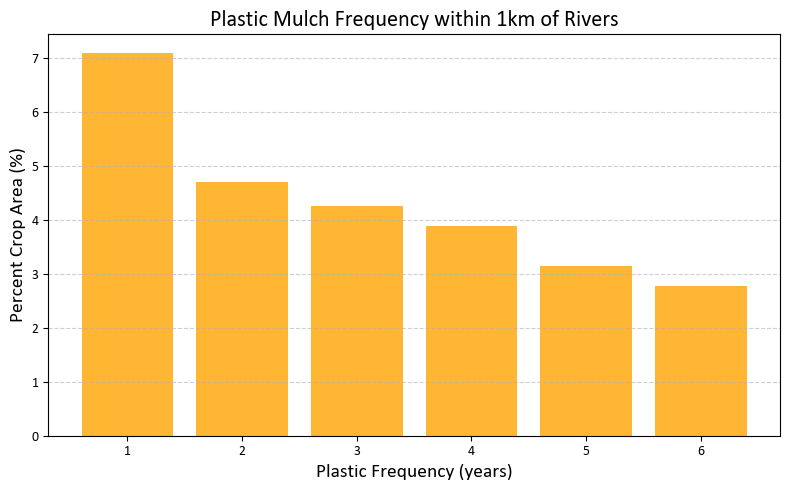

In [57]:
# import csv with number of pixels in each frequency class by river in each county
freq_df = pd.read_csv('C:/Users/annie.taylor/Documents/Plastics/ag-plastics/data/Mulch_freq_All_Rivers.csv')

# convert pixel counts to area in km2
pixel_area_km2 = 100 / 1e6  # area of one 10m pixel in km²
freq_df['areakm_crops'] = freq_df['count_crops'] * pixel_area_km2
# freq_df['areakm_noncrops'] = freq_df['count_noncrops'] * pixel_area_km2

# also calc the percent area in each freq class for each river, based on areakm_crop
for i in range(0, 7):
    freq_df[f'areakm_{i}'] = freq_df[f'count_{i}'] * pixel_area_km2
    freq_df[f'pct_{i}'] = (freq_df[f'areakm_{i}'] / freq_df['areakm_crops']) * 100

freq_df['ThreePlus_km2'] = freq_df[['areakm_3', 'areakm_4', 'areakm_5', 'areakm_6']].sum(axis=1)
freq_df['ThreePlus_pct'] = (freq_df['ThreePlus_km2'] / freq_df['areakm_crops']) * 100

display(freq_df)

# sum for all rivers -- percent of area mulch three or more times in six years
total_crops_km2 = freq_df['areakm_crops'].sum()
total_threeplus_km2 = freq_df['ThreePlus_km2'].sum()
display('Percent of crop area within 1km of rivers that was mulched 3+ times: ',
    (total_threeplus_km2 / total_crops_km2) * 100
)


# chart the number of pixels in each frequency class for all rivers combined

freq_df.drop(columns=['count_0'], inplace=True)
# Sum the counts for each frequency class across all rivers
freq_classes = [f'areakm_{i}' for i in range(1, 7)]
area_sums = freq_df[freq_classes].sum()

percent_sums = (area_sums/total_crops_km2) * 100
print('Percent sums:', percent_sums)

# change font to calibri
plt.rcParams["font.family"] = "Calibri"

# plt.figure(figsize=(8, 5))
# plt.bar(range(6), area_sums, color='maroon', alpha=0.8)
# plt.xlabel('Plastic Frequency (years)', fontsize=14)
# plt.ylabel('Area (km²)', fontsize=14)
# plt.title('Plastic Mulch Frequency within 1km of Rivers', fontsize=16)
# plt.xticks(range(6), [str(i) for i in range(1, 7)])
# plt.grid(axis='y', linestyle='--', alpha=0.6)
# plt.tight_layout()
# plt.show()

plt.figure(figsize=(8, 5))
plt.bar(range(6), percent_sums, color='orange', alpha=0.8)
plt.xlabel('Plastic Frequency (years)', fontsize=14)
plt.ylabel('Percent Crop Area (%)', fontsize=14)
plt.title('Plastic Mulch Frequency within 1km of Rivers', fontsize=16)
plt.xticks(range(6), [str(i) for i in range(1, 7)])
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## 12. Archive

### old method - Get area of mulch and hoop coverage from final WY rasters for each county, save to csv
takes about a minute to run

In [ ]:
# county = santabarbara
# wys = [2019, 2020, 2021, 2022, 2023, 2024]

# county_name = county.first().get('NAME').getInfo().replace(" ", "")

# # Create a pixel area image. Pixel values are square meters based on a given CRS and scale (or CRS transform).
# pixel_area = ee.Image.pixelArea()
# # The default projection is WGS84 with 1-degree scale.
# # display('Pixel area default projection', pixel_area.projection())

# df_county_ts = []

# for wy in wys:
#     # import asset
#     ras = ee.Image(f'projects/ee-tnc-annietaylor/assets/agplastics/PlasticClass_{county_name}Co_WY{wy}_v1_2')

#     # reproject the raster (doesn't appear necessary, results identical) 
#     ras = ras.reproject(crs='EPSG:3310', scale=10)

#     hoop = ras.select('class').eq(1)
#     mulch = ras.select('class').eq(2) # TODO print these to map to double check

#     hoop_area = pixel_area.updateMask(hoop)
#     mulch_area = pixel_area.updateMask(mulch)

#     hoop_area_calc = hoop_area.reduceRegion(
#         reducer=ee.Reducer.sum(),
#         geometry=county.geometry(),
#         crs=ee.Projection('EPSG:3310'),
#         scale=10,
#         maxPixels=1e8,
#     )

#     mulch_area_calc = mulch_area.reduceRegion(
#         reducer=ee.Reducer.sum(),
#         geometry=county.geometry(),
#         crs=ee.Projection('EPSG:3310'),
#         scale=10,
#         maxPixels=1e8,
#     )

#     hoop_m2 = hoop_area_calc.getNumber('area').getInfo()
#     mulch_m2 = mulch_area_calc.getNumber('area').getInfo()

#     # save these numbers to a dataframe
#     data = {
#         'Year': [wy],
#         'County': [county_name],
#         'Hoop_m2': [hoop_m2],
#         'Hoop_acres': [(hoop_m2/4046.8564224)], # to convert m2 to acres
#         'Mulch_m2': [mulch_m2],
#         'Mulch_acres': [(mulch_m2/4046.8564224)]
#     }
#     df_county_ts.append(pd.DataFrame(data))

# df_area = pd.concat(df_county_ts)
# display(df_area)

### Calculate acreage as percent of ag lands

In [ ]:
# all_ag = ee.Image('projects/ee-tnc-annietaylor/assets/agplastics/dwr_allyears_23')

# # clip to county
# county_ag = all_ag.clip(county)

# # reproject the raster
# county_ag = county_ag.reproject(crs='EPSG:3310', scale=10)

# # mask pixel area image to ag lands
# ag_area = pixel_area.updateMask(county_ag)

# ag_area_calc = ag_area.reduceRegion(
#     reducer=ee.Reducer.sum(),
#     geometry=county.geometry(),
#     crs=ee.Projection('EPSG:3310'),
#     scale=10,
#     maxPixels=1e8,
# )

# # extract area and add to a df
# ag_area_m2 = ag_area_calc.getNumber('area').getInfo()

# results = {
#     'County': county_name,
#     'Ag_m2': ag_area_m2,
#     'Ag_acres': (ag_area_m2/4046.8564224)
# }

# display(results)

# # add a column to df_area standardized by ag land area in that county
# df_area['Hoop_acres_percent'] = df_area['Hoop_acres'] / results['Ag_acres']
# df_area['Mulch_acres_percent'] = df_area['Mulch_acres'] / results['Ag_acres']
# df_area


In [ ]:
# # save to a csv for import into a stacked chart
# # csv_name = f'N:/OCEANS_Program/Plastics/Agricultural_Plastics/Area_by_County/plasticAreaOverTime_{county_name}County_v1_2.csv'
# csv_name = f'C:/Users/annie.taylor/Documents/Plastics/ag-plastics/data/Area_by_County/plasticAreaOverTime_{county_name}County_v1_2.csv'
# df_area.to_csv(csv_name, index=False)


### Plot plastic acreage over time - one county

In [ ]:
# county_name = county_name.replace("Santa", "Santa ")
# # Plot the change in mulch_acres and hoop_acres over Year side by side
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

# # Plot for Mulch Acres
# ax1.plot(df_area['Year'], df_area['Mulch_acres'], marker='o', linestyle='-', color='orange')
# ax1.set_ylabel('Acres of Plastic Mulch')
# ax1.set_title(f'Plastic Mulch Acreage in {county_name} County')
# ax1.set_xticks(df_area['Year'])  # Set x-axis ticks to be the integer values of the year

# # Plot for Hoop Acres
# ax2.plot(df_area['Year'], df_area['Hoop_acres'], marker='o', linestyle='-', color='darkred')
# ax2.set_ylabel('Acres of Hoop Houses')
# ax2.set_title(f'Hoop House Acreage in {county_name} County')
# ax2.set_xticks(df_area['Year'])  # Set x-axis ticks to be the integer values of the year

# plt.show()

### Plot plastic percent of acreage over time

In [ ]:
# # Plot the change in mulch_acres_percent and hoop_acres_percent over year side by side
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

# # Plot for Mulch Acres
# ax1.plot(df_area['Year'], df_area['Mulch_acres_percent'], marker='o', linestyle='-', color='orange')
# ax1.set_ylabel('Plastic Mulch Coverage of Ag Land (%)')
# ax1.set_title(f'Plastic Mulch % Coverage in {county_name} County')
# ax1.set_xticks(df_area['Year'])  # Set x-axis ticks to be the integer values of the year

# # Plot for Hoop Acres
# ax2.plot(df_area['Year'], df_area['Hoop_acres_percent'], marker='o', linestyle='-', color='darkred')
# ax2.set_ylabel('Hoop House Coverage of Ag Land (%)')
# ax2.set_title(f'Hoop House % Coverage in {county_name} County')
# ax2.set_xticks(df_area['Year'])  

# plt.show()

### OLD Area charts - import csvs with area calculations
ARCHIVE

In [ ]:
# # import all three csvs and combine into one df
# # df_sb = pd.read_csv(r'N:/OCEANS_Program/Plastics/Agricultural_Plastics/Area_by_County/plasticAreaOverTime_SantaBarbaraCounty_v1_2.csv')
# # df_vt = pd.read_csv(r'N:/OCEANS_Program/Plastics/Agricultural_Plastics/Area_by_County/plasticAreaOverTime_VenturaCounty_v1_2.csv')
# # df_sc = pd.read_csv(r'N:/OCEANS_Program/Plastics/Agricultural_Plastics/Area_by_County/plasticAreaOverTime_SantaCruzCounty_v1_2.csv')

# df_sb = pd.read_csv(r'C:/Users/annie.taylor/Documents/Plastics/ag-plastics/data/Area_by_County/plasticAreaOverTime_SantaBarbaraCounty_v1_2.csv')
# df_vt = pd.read_csv(r'C:/Users/annie.taylor/Documents/Plastics/ag-plastics/data/Area_by_County/plasticAreaOverTime_VenturaCounty_v1_2.csv')
# df_sc = pd.read_csv(r'C:/Users/annie.taylor/Documents/Plastics/ag-plastics/data/Area_by_County/plasticAreaOverTime_SantaCruzCounty_v1_2.csv')

# df_all = pd.concat([df_sb, df_vt, df_sc])
# df_all['Hoop_acres_percent'] *= 100 #adjusting this for plotting
# df_all['Mulch_acres_percent'] *= 100
# df_all['County_Name'] = df_all['County'].str.replace('Santa', 'Santa ')
# # df_all.to_csv('N:/OCEANS_Program/Plastics/Agricultural_Plastics/Area_by_County/plasticAreaOverTime_allCounties_v1_2.csv', index=False)

# # filter for just wy2024 rows and display
# df_wy2024 = df_all[df_all['Year'] == 2024][['Year', 'County_Name', 'Hoop_acres', 'Mulch_acres']]
# display(df_wy2024)

#### Stacked area charts - counties side by side

In [ ]:
# # iterate through the three counties' dataframes to plot them
# df_list = [df_sc, df_sb, df_vt] # in order N to S

# fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# for ax, df in zip(axes, df_list):
#     location = df['County'].unique()[0].replace('Santa', 'Santa ')
#     ax.stackplot(df['Year'], df['Hoop_acres'], df['Mulch_acres'], labels=['Hoop House', 'Mulch'], colors=['coral', 'lightseagreen'], alpha=0.7)
#     ax.set_title(f'{location} County')
#     ax.set_xlabel('Water Year')
#     ax.set_xticks(df['Year'])
#     ax.grid(axis='x', linestyle='-', color='white')
#     ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
#     ax.set_ylabel('Acres')
# axes[2].legend()

# plt.tight_layout()
# plt.show()

# fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# for ax, df in zip(axes, df_list):
#     df['Hoop_acres_percent'] *= 100 #TODO just convert this at the creation stage, not here
#     df['Mulch_acres_percent'] *= 100
#     location = df['County'].unique()[0].replace('Santa', 'Santa ')
#     ax.stackplot(df['Year'], df['Hoop_acres_percent'], df['Mulch_acres_percent'], labels=['Hoop House', 'Mulch'], colors=['coral', 'lightseagreen'], alpha=0.7)
#     ax.set_title(f'{location} County')
#     ax.set_xlabel('Water Year')
#     ax.set_xticks(df['Year'])
#     ax.grid(axis='x', linestyle='-', color='white')
#     ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
#     ax.set_ylabel('Percent of Ag Area')
# axes[2].legend()

# plt.tight_layout()
# plt.show()

#### Stacked area charts - mulch and hoop split

In [ ]:
# # create a stacked area chart with all three counties together using df_all
# fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
# # Add space after 'Santa' in the County column for display

# ax1, ax2 = axes
# # Create the stacked area chart for Hoop Acres
# ax1.stackplot(df_all['Year'].unique(), df_all.pivot(index='Year', columns='County_Name', values='Mulch_acres').fillna(0).T, labels=df_all['County_Name'].unique(), alpha=0.5)
# ax1.set_title('Mulch Acres by County')
# ax1.set_xlabel('Water Year')
# ax1.set_ylabel('Acres')
# ax1.set_xticks(df['Year'])
# ax1.grid(axis='x', linestyle='-', color='white')
# ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
# # ax1.legend()

# # Create the stacked area chart for Mulch Acres
# ax2.stackplot(df_all['Year'].unique(), df_all.pivot(index='Year', columns='County_Name', values='Hoop_acres').fillna(0).T, labels=df_all['County_Name'].unique(), alpha=0.5)
# ax2.set_title('Hoop Acres by County')
# ax2.set_xlabel('Water Year')
# ax2.set_ylabel('Acres')
# ax2.set_xticks(df['Year'])
# ax2.grid(axis='x', linestyle='-', color='white')
# ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
# ax2.legend()

#### Stacked area chart - all acres combined

In [ ]:
# # Create a stacked area chart with all three counties together using df_all
# fig, ax = plt.subplots(figsize=(9, 6))

# # Pivot the dataframe to get the data in the right format for stacking
# pivot_df = df_all.pivot(index='Year', columns='County_Name', values=['Hoop_acres', 'Mulch_acres'])

# color_map = ["coral", "sandybrown", "peachpuff", "lightseagreen", "mediumaquamarine", "lightgreen"]


# # Plot the stacked area chart for Hoop and Mulch Acres
# ax.stackplot(pivot_df.index, 
#              pivot_df['Hoop_acres'].T, 
#              pivot_df['Mulch_acres'].T, 
#              labels=[f'{county} Hoop' for county in pivot_df['Hoop_acres'].columns] + [f'{county} Mulch' for county in pivot_df['Mulch_acres'].columns], 
#              alpha=0.8,
#              colors=color_map)

# # Set the title and labels
# ax.set_title('Hoop and Mulch Acres by County')
# ax.set_xlabel('Water Year')
# ax.set_ylabel('Acres')
# ax.set_xticks(df_all['Year'].unique())
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
# ax.grid(axis='x', linestyle='-', color='white')
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

# # export the plot as an svg for sara
# # plt.savefig('N:/OCEANS_Program/Plastics/Agricultural_Plastics/Maps_Figures/Hoop_Mulch_Acres_by_County.svg', format='svg', bbox_inches='tight')

# # Show the plot
# plt.show()

#### Area of plastic -- side by side hoop vs mulch

In [ ]:
# # Calculate percent change of total plastic mulch acres over each year
# # Sum mulch acres across all three counties for each year
# years = df_sb['Year']
# total_mulch_acres = df_sb['Mulch_acres'].values + df_vt['Mulch_acres'].values + df_sc['Mulch_acres'].values
# total_hoop_acres = df_sb['Hoop_acres'].values + df_vt['Hoop_acres'].values + df_sc['Hoop_acres'].values
# # percent_change = 100 * (total_mulch_acres[1:] - total_mulch_acres[:-1]) / total_mulch_acres[:-1]

# change_df = pd.DataFrame({
#     'Year': years,
#     'Total_Mulch_Acres': total_mulch_acres,
#     'Total_Hoop_Acres': total_hoop_acres
# })

# change_df['Percent_Change_Mulch'] = change_df['Total_Mulch_Acres'].pct_change() * 100
# change_df['Percent_Change_Hoop'] = change_df['Total_Hoop_Acres'].pct_change() * 100

# # Format percent change columns to add '+' for positive values
# change_df['Percent_Change_Mulch_fmt'] = change_df['Percent_Change_Mulch'].apply(lambda x: f"+{x:.1f}%" if pd.notnull(x) and x > 0 else f"{x:.1f}%" if pd.notnull(x) else "")
# change_df['Percent_Change_Hoop_fmt'] = change_df['Percent_Change_Hoop'].apply(lambda x: f"+{x:.1f}%" if pd.notnull(x) and x > 0 else f"{x:.1f}%" if pd.notnull(x) else "")

# display(change_df)

# # chart it
# fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# # Left: Hoop Acres stacked area chart
# axes[0].stackplot(
#     df_sb['Year'], df_vt['Hoop_acres'], df_sb['Hoop_acres'], df_sc['Hoop_acres'],
#     labels=['Ventura', 'Santa Barbara', 'Santa Cruz'],
#     colors=["#0072B2", "#009E73", "#E69F00"], alpha=0.7  # blue, green, orange (colorblind safe)
# )
# axes[0].set_title('Hoop house acres by county')
# axes[0].set_xlabel('Water Year')
# axes[0].set_ylabel('Acres')
# axes[0].set_xticks(df_sb['Year'])
# axes[0].legend()
# axes[0].grid(axis='x', linestyle='-', color='white')

# # Right: Mulch Acres stacked area chart
# axes[1].stackplot(
#     df_sb['Year'], df_vt['Mulch_acres'], df_sb['Mulch_acres'], df_sc['Mulch_acres'],
#     labels=['Ventura', 'Santa Barbara', 'Santa Cruz'],
#     colors=["#0072B2", "#009E73", "#E69F00"], alpha=0.7
# )
# axes[1].set_title('Plastic mulch acres by county')
# axes[1].set_xlabel('Water Year')
# axes[1].set_xticks(df_sb['Year'])
# # axes[1].legend()
# axes[1].grid(axis='x', linestyle='-', color='white')
# axes[1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
# for ax in axes:
#     ax.tick_params(axis='both', labelsize=10)
#     ax.set_title(ax.get_title(), fontname='Calibri', fontsize=14)
#     ax.set_xlabel(ax.get_xlabel(), fontname='Calibri', fontsize=12)
#     ax.set_ylabel(ax.get_ylabel(), fontname='Calibri', fontsize=12)
#     for text in ax.texts:
#         text.set_fontname('Calibri')
#     for label in (ax.get_xticklabels() + ax.get_yticklabels()):
#         label.set_fontname('Calibri')


# # Annotate percent change values on the mulch and hoop charts
# for i, year in enumerate(years[1:], start=1):
#     # Mulch percent change annotation (right plot)
#     pct = change_df.loc[i, 'Percent_Change_Mulch_fmt']
#     axes[1].annotate(pct, (year, total_mulch_acres[i]),
#                      textcoords="offset points", xytext=(0, 6), ha='center', fontsize=9, color='black')
#     # Hoop percent change annotation (left plot)
#     pct_hoop = change_df.loc[i, 'Percent_Change_Hoop_fmt']
#     axes[0].annotate(pct_hoop, (year, total_hoop_acres[i]),
#                      textcoords="offset points", xytext=(0, 5), ha='center', fontsize=9, color='black')

# plt.tight_layout()
# plt.show()
# # display(change_df)

#### Get total percent coverage across all counties

In [ ]:
# # Define the three counties
# counties = [santabarbara, ventura, cruz]

# # Initialize a list to store the results
# results_list = []

# # Loop through each county and calculate the agricultural area
# for county in counties:
#     # Get the county name
#     county_name = county.first().get('NAME').getInfo()
    
#     # Clip the all_ag image to the county
#     county_ag = all_ag.clip(county)
    
#     # Reproject the raster
#     county_ag = county_ag.reproject(crs='EPSG:3310', scale=10)
    
#     # Mask pixel area image to ag lands
#     ag_area = pixel_area.updateMask(county_ag)
    
#     # Calculate the area
#     ag_area_calc = ag_area.reduceRegion(
#         reducer=ee.Reducer.sum(),
#         geometry=county.geometry(),
#         crs=ee.Projection('EPSG:3310'),
#         scale=10,
#         maxPixels=1e8,
#     )
    
#     # Extract area in square meters and convert to acres
#     ag_area_m2 = ag_area_calc.getNumber('area').getInfo()
#     ag_area_acres = ag_area_m2 / 4046.8564224
    
#     # Add the result to the list
#     results_list.append({
#         'County': county_name,
#         'Ag_acres': ag_area_acres
#     })

# # Convert the list to a dataframe
# df_ag_acres = pd.DataFrame(results_list)

# # Display the dataframe
# display(df_ag_acres)
# total_ag_acres = df_ag_acres['Ag_acres'].sum()
# display('Total ag acres across counties: ', total_ag_acres)

# # Add a column to df_all standardized by total ag land area across all counties
# df_all['Hoop_acres_percent_all'] = df_all['Hoop_acres'] / total_ag_acres * 100
# df_all['Mulch_acres_percent_all'] = df_all['Mulch_acres'] / total_ag_acres * 100
# # df_all


#### Stacked area chart - percent of total ag area combined

In [ ]:
# # Create a stacked area chart with all three counties together using df_all
# fig, ax = plt.subplots(figsize=(9, 6))

# # Pivot the dataframe to get the data in the right format for stacking
# pivot_df = df_all.pivot(index='Year', columns='County_Name', values=['Hoop_acres_percent_all', 'Mulch_acres_percent_all'])

# color_map = ["coral", "sandybrown", "peachpuff", "lightseagreen", "mediumaquamarine", "lightgreen"]


# # Plot the stacked area chart for Hoop and Mulch Acres
# ax.stackplot(pivot_df.index, 
#              pivot_df['Hoop_acres_percent_all'].T, 
#              pivot_df['Mulch_acres_percent_all'].T, 
#              labels=[f'{county} Hoop' for county in pivot_df['Hoop_acres_percent_all'].columns] + [f'{county} Mulch' for county in pivot_df['Mulch_acres_percent_all'].columns], 
#              alpha=0.8,
#              colors=color_map)

# # Set the title and labels
# ax.set_title('Hoop and Mulch Percent of Total Ag Area')
# ax.set_xlabel('Water Year')
# ax.set_ylabel('Percent of Total Ag Area')
# ax.set_xticks(df_all['Year'].unique())
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
# ax.grid(axis='x', linestyle='-', color='white')
# ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())

# # Show the plot
# plt.show()

### Get area calcs for field-classification rasters
only have wy24 right now, test difference from existing data

In [ ]:
# # Create a pixel area image. Pixel values are square meters based on a given CRS and scale (or CRS transform).
# pixel_area = ee.Image.pixelArea()
# # The default projection is WGS84 with 1-degree scale.
# # display('Pixel area default projection', pixel_area.projection())

# counties = [cruz, ventura, santabarbara]
# wy = 2024

# df_county_ts = []

# for county in counties:
#     county_name = county.first().get('NAME').getInfo().replace(" ", "")

#     # import asset
#     ras = ee.Image(f'projects/ee-tnc-annietaylor/assets/PlasticClass_{county_name}Co_WY{wy}_v1_2_prj_majority_wgs')

#     # reproject the raster (doesn't appear necessary, results identical) 
#     ras = ras.reproject(crs='EPSG:3310', scale=10)

#     hoop = ras.select('b1').eq(1)
#     mulch = ras.select('b1').eq(2) # TODO print these to map to double check

#     hoop_area = pixel_area.updateMask(hoop)
#     mulch_area = pixel_area.updateMask(mulch)

#     hoop_area_calc = hoop_area.reduceRegion(
#         reducer=ee.Reducer.sum(),
#         geometry=county.geometry(),
#         crs=ee.Projection('EPSG:3310'),
#         scale=10,
#         maxPixels=1e8,
#     )

#     mulch_area_calc = mulch_area.reduceRegion(
#         reducer=ee.Reducer.sum(),
#         geometry=county.geometry(),
#         crs=ee.Projection('EPSG:3310'),
#         scale=10,
#         maxPixels=1e8,
#     )

#     hoop_m2 = hoop_area_calc.getNumber('area').getInfo()
#     mulch_m2 = mulch_area_calc.getNumber('area').getInfo()

#     # save these numbers to a dataframe
#     data = {
#         'Year': [wy],
#         'County': [county_name],
#         'Hoop_m2': [hoop_m2],
#         'Hoop_acres': [(hoop_m2/4046.8564224)], # to convert m2 to acres
#         'Mulch_m2': [mulch_m2],
#         'Mulch_acres': [(mulch_m2/4046.8564224)]
#     }
#     df_county_ts.append(pd.DataFrame(data))

# df_area = pd.concat(df_county_ts)


In [ ]:
# display('pixel:', df_wy2024)
# county_order = ['SantaCruz', 'Ventura', 'SantaBarbara']
# df_area_sorted = df_area.set_index('County').loc[county_order].reset_index()
# display('field:', df_area_sorted[['Year', 'County', 'Hoop_acres', 'Mulch_acres']])

### Add final classifications to map

In [ ]:
# wy = 2023
# county_name = 'SantaBarbara'

# ras = ee.Image(f'projects/ee-tnc-annietaylor/assets/agplastics/PlasticClass_{county_name}Co_WY{wy}_int_v2')

# # add to map
# m = geemap.Map()
# m.add_basemap('SATELLITE')
# m.addLayer(ras.select('class'), {'min': 0, 'max': 2, 'palette': ['blue', 'red', 'yellow']}, 'Final Classes')
# m.centerObject(ca, 6)
# m

In [ ]:
# convert watsonville df to a geopandas df
# gdf = gpd.GeoDataFrame(watsonville, geometry=gpd.points_from_xy(watsonville.Longitude, watsonville.Latitude))
# gdf = gdf.set_crs('EPSG:4326')

# plot the points
# fig, ax = plt.subplots(figsize=(10, 10))
# gdf.plot(ax=ax, color='red', markersize=10)
# plt.show()

# src = rasterio.open('N:\OCEANS_Program\Plastics\Agricultural_Plastics\AgPlastics_Pro\EE_uploads_exports\Watsonville\Plastic_SantaCruzCo_95p_WY2023.tif')

# # plot points with raster
# fig, ax = plt.subplots()
# # transform rasterio plot to real world coords
# extent = [src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
# extent = [-121.9, src.bounds[2], src.bounds[1], 37.0]
# ax = rasterio.plot.show(mulch, extent=extent, ax=ax, cmap="viridis")
# gdf.plot(ax=ax, color='red', markersize=0.5)
# # print(extent)



In [ ]:
# old acreage calculation
# plastic_type = 'mulch_p95'
# county = ventura

# # I've shared these from my personal EE account
# plastic_2019_95p = ee.Image('projects/ee-annalisertaylor/assets/TNC/agplastics/PlasticClass_VenturaCo_95p_2019_mask75')
# plastic_2023_95p = ee.Image('projects/ee-annalisertaylor/assets/TNC/agplastics/PlasticClass_VenturaCo_95p_2023_mask75')

# # Create a pixel area image. Pixel values are square meters based on
# # a given CRS and scale (or CRS transform).
# pixel_area = ee.Image.pixelArea()

# # The default projection is WGS84 with 1-degree scale.
# # display('Pixel area default projection', pixel_area.projection())

# plastic_2019 = plastic_2019_95p.select(plastic_type).gt(0)
# plastic_2023 = plastic_2023_95p.select(plastic_type).gt(0)

# # Apply the hoop or mulch classified area mask to the pixel area image.
# plastic_area_2019 = pixel_area.updateMask(plastic_2019)
# plastic_area_2023 = pixel_area.updateMask(plastic_2023)

# area_2019 = plastic_area_2019.reduceRegion(
#     reducer=ee.Reducer.sum(),
#     geometry=county.geometry(),
#     crs=ee.Projection('EPSG:3310'),
#     # crs=hoop.projection(),
#     scale=10,
#     maxPixels=1e8,
# )

# area_2023 = plastic_area_2023.reduceRegion(
#     reducer=ee.Reducer.sum(),
#     geometry=county.geometry(),
#     crs=ee.Projection('EPSG:3310'),
#     # crs=hoop.projection(),
#     scale=10,
#     maxPixels=1e8,
# )

# square_meters_19 = area_2019.getNumber('area')
# acres_19 = square_meters_19.divide(4046.8564224) # to convert m2 to acres

# square_meters_23 = area_2023.getNumber('area')
# acres_23 = square_meters_23.divide(4046.8564224) # to convert m2 to acres

# display(f'Area of {plastic_type} in 2019  m2: {square_meters_19.getInfo()}, acres: {acres_19.getInfo()}')
# display(f'Area of {plastic_type} in 2023  m2: {square_meters_23.getInfo()}, acres: {acres_23.getInfo()}')

#### All counties combined - line plot

In [ ]:
# # Plot hoop acres and mulch acres for each county
# fig, ax = plt.subplots(figsize=(10, 6))

# # Set color cycle
# colors = ['mediumaquamarine', 'mediumaquamarine', 'tomato', 'tomato', 'slateblue', 'slateblue']
# ax.set_prop_cycle(color=colors)

# for county in df_all['County'].unique():
#     county_data = df_all[df_all['County'] == county]
#     county = county.replace('Santa', 'Santa ')
#     ax.plot(county_data['Year'], county_data['Hoop_acres_percent'], label=f'{county} Hoop', linestyle='-', marker='o')
#     ax.plot(county_data['Year'], county_data['Mulch_acres_percent'], label=f'{county} Mulch', linestyle='--', marker='o')

# legend_elements = [
#     Line2D([0], [0], marker='o', color='mediumaquamarine', markerfacecolor='mediumaquamarine', lw=2, label='Santa Barbara County', linestyle='-'),
#     Line2D([0], [0], marker='o', color='tomato', markerfacecolor='tomato', lw=2, label='Ventura County', linestyle='-'),
#     Line2D([0], [0], marker='o', color='slateblue', markerfacecolor='slateblue', lw=2, label='Santa Cruz County', linestyle='-'),
#     Line2D([0], [0], color='black', lw=2, label='Hoop', linestyle='-'),
#     Line2D([0], [0], color='black', lw=2, label='Mulch', linestyle='--')
# ]

# ax.set_xlabel('Water Year')
# ax.set_ylabel('Percent of Ag Area in County')
# ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
# ax.legend(handles=legend_elements)#, loc='center left', bbox_to_anchor=(1, 0.5))
# ax.set_xticks(df_all['Year'])  # Set x-axis ticks to be the integer values of the year
# ax.set_ylim(bottom=0)
# plt.show()

In [ ]:
# # Plot hoop acres and mulch acres for each county
# fig, ax = plt.subplots(figsize=(10, 6))

# # Set color cycle
# colors = ['mediumaquamarine', 'mediumaquamarine', 'tomato', 'tomato', 'slateblue', 'slateblue']
# ax.set_prop_cycle(color=colors)

# for county in df_all['County'].unique():
#     county_data = df_all[df_all['County'] == county]
#     county = county.replace('Santa', 'Santa ')
#     ax.plot(county_data['Year'], county_data['Hoop_acres'], label=f'{county} Hoop', linestyle='-', marker='o')
#     ax.plot(county_data['Year'], county_data['Mulch_acres'], label=f'{county} Mulch', linestyle='--', marker='o')

# # Separate the legend so that county is distinguished by color and hoop/mulch is distinguished by solid/dashed lines
# legend_elements = [
#     Line2D([0], [0], marker='o', color='mediumaquamarine', markerfacecolor='mediumaquamarine', lw=2, label='Santa Barbara County', linestyle='-'),
#     Line2D([0], [0], marker='o', color='tomato', markerfacecolor='tomato', lw=2, label='Ventura County', linestyle='-'),
#     Line2D([0], [0], marker='o', color='slateblue', markerfacecolor='slateblue', lw=2, label='Santa Cruz County', linestyle='-'),
#     Line2D([0], [0], color='black', lw=2, label='Hoop', linestyle='-'),
#     Line2D([0], [0], color='black', lw=2, label='Mulch', linestyle='--')
# ]

# ax.set_xlabel('Water Year')
# ax.set_ylabel('Acres')
# ax.legend(handles=legend_elements)#, loc='center left', bbox_to_anchor=(1, 0.5))
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
# ax.set_xticks(df_all['Year'])  # Set x-axis ticks to be the integer values of the year
# ax.set_ylim(bottom=0)
# plt.show()

### Area calculation with rioxarray to double check results

In [ ]:
# set county
county_name = 'Santa Cruz'

# Define the folder containing the tif files and the shapefile path
tif_folder = 'N:/OCEANS_Program/Plastics/Agricultural_Plastics/AgPlastics_Pro/EE_uploads_exports'
shapefile_path = 'N:/California/data/administrative/California_Counties_2024/California_Counties.shp'

# Read the shapefile and grab the county of interest
shapefile = gpd.read_file(shapefile_path)
county_shp = shapefile[shapefile['NAME'] == (county_name + ' County')]
# project county_shp to EPSG:3310
county_shp = county_shp.to_crs('EPSG:3310')
# display(county_shp)#, county_shp.crs)

# # test / visualize one raster at a time
# wy = 2019
# county_var = county_name.replace(" ", "")
# tif_path = os.path.join(tif_folder, f'PlasticClass_{county_var}Co_WY{wy}_int_v2.tif')

# # import the raster as an xarray object
# plastic_ras = rioxarray.open_rasterio(tif_path, masked=True).squeeze()
# # Reproject the raster (I believe this is using nearest neighbor)
# plastic_ras_prj = plastic_ras.rio.reproject(county_shp.crs)
# # display(plastic_ras_prj.rio.crs)

# # print out the map
# f, ax = plt.subplots(figsize=(10, 4))

# plastic_ras_prj.plot.imshow(ax=ax)#, cmap='Greys')
# county_shp.plot(color='None',
#                     edgecolor='white',
#                     linewidth=1,
#                     ax=ax)
# ax.set(title=f"Plastic Classification for {county_name} County in {wy}")
# ax.set_axis_off()
# plt.show()

# histogram to check for weird na values
# plastic_ras_prj.plot.hist(color="purple")

wys = [2019, 2020, 2021, 2022, 2023]
county_var = county_name.replace(" ", "")
df_county_ts = []

for wy in wys: 
    tif_path = os.path.join(tif_folder, f'PlasticClass_{county_var}Co_WY{wy}_int_v2.tif')
    # import the raster as an xarray object
    plastic_ras = rioxarray.open_rasterio(tif_path, masked=True).squeeze()
    # Reproject the raster (I believe this is using nearest neighbor) and clip to county
    plastic_ras_prj = plastic_ras.rio.reproject(county_shp.crs)
    plastic_ras_clipped = plastic_ras_prj.rio.clip(county_shp.geometry)
    pixel_area_m2 = abs(plastic_ras_clipped.rio.resolution()[0] * plastic_ras_clipped.rio.resolution()[1])
    pixel_area_acres = pixel_area_m2 / 4046.8564224

    # Calculate the number of pixels for each band value (1 and 2) within the clipped raster
    unique, counts = np.unique(plastic_ras_clipped, return_counts=True)
    pixel_counts = dict(zip(unique, counts))

    # Multiply the pixel counts by the area of each pixel to get the area of each band value
    area_counts = {value: count * pixel_area_acres for value, count in pixel_counts.items()}


    # save these numbers to a dataframe
    data = {
        'Year': [wy],
        'County': [county_name],
        'Hoop_acres': [area_counts.get(1)],
        'Mulch_acres': [area_counts.get(2)]
    }
    df_county_ts.append(pd.DataFrame(data))

df_area = pd.concat(df_county_ts)
display(df_area)

#### percent of ag area - santa cruz county only

In [ ]:
# this is only for santa cruz, had to reproject, clip, and reclass it in pro due to size limits when running in rioxarray
all_ag = 'N:/OCEANS_Program/Plastics/Agricultural_Plastics/AgPlastics_Pro/EE_uploads_exports/dwr_allyears_cruz_reclass.tif'

# calculate ag area in county
ag_ras = rioxarray.open_rasterio(all_ag, masked=True).squeeze()
# ag_ras_prj = ag_ras.rio.reproject(county_shp.crs) # this raster is already project
ag_ras_clipped = ag_ras.rio.clip(county_shp.geometry) #and should already be clipped but this is safest

# ag_ras_clipped.plot.hist(color="purple")
pixel_area_m2 = abs(ag_ras_clipped.rio.resolution()[0] * ag_ras_clipped.rio.resolution()[1])
pixel_area_acres = pixel_area_m2 / 4046.8564224

# Filter the raster to only values greater than 0 and not NAN
# ag_ras_filtered = ag_ras_clipped.where((ag_ras_clipped > 0) & (~np.isnan(ag_ras_clipped)))

# set all values of the raster greater than 0 to a value of 1
# ag_ras_reset = ag_ras_clipped.where(ag_ras_clipped > 0, 0)

# Calculate the number of pixels for each band value (1 and 2) within the clipped raster
unique, counts = np.unique(ag_ras_clipped, return_counts=True)
pixel_counts = dict(zip(unique, counts))

# Multiply the pixel counts by the area of each pixel to get the area of each band value
area_counts = {value: count * pixel_area_acres for value, count in pixel_counts.items()}

# Sum up all the values in the dictionary
total_area_acres = area_counts.get(1)
display(total_area_acres)

# santa cruz is 18378.100519 ag acres with EE, 18374.072926411085 acres with rioxarray

# add a column to df_area standardized by ag land area in that county
df_area['Hoop_acres_percent'] = df_area['Hoop_acres'] / total_area_acres
df_area['Mulch_acres_percent'] = df_area['Mulch_acres'] / total_area_acres
df_area

#### Plot the results

In [ ]:
# Plot the change in mulch_acres and hoop_acres over Year side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

# Plot for Mulch Acres
ax1.plot(df_area['Year'], df_area['Mulch_acres'], marker='o', linestyle='-', color='orange')
ax1.set_ylabel('Acres of Plastic Mulch')
ax1.set_title(f'Plastic Mulch Acreage in {county_name} County')
ax1.set_xticks(df_area['Year'])  # Set x-axis ticks to be the integer values of the year

# Plot for Hoop Acres
ax2.plot(df_area['Year'], df_area['Hoop_acres'], marker='o', linestyle='-', color='darkred')
ax2.set_ylabel('Acres of Hoop Houses')
ax2.set_title(f'Hoop House Acreage in {county_name} County')
ax2.set_xticks(df_area['Year'])  # Set x-axis ticks to be the integer values of the year

plt.show()